In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle
import scipy.io as scio
import itertools
import scipy.stats

In [2]:
from helper_func import load_matlab_struct, filter_by_index
from ellipse_helper import fit_ellipse, cart_to_pol, get_ellipse_pts
from plotting_func import radar_factory
from likelihood_models import RandomCorrect, WeightedSub, WeightedMult, WeightedAverage

## Non-Image-Computable models

In [3]:
def delta(data, idx, target):
    r = data['response'][idx] * np.pi/180
    if target:
        x = data['T'][idx] * np.pi/180
    else:
        x = data['ensemble_mean'][idx] * np.pi/180
        
    # get the probabilities   
    out = np.zeros_like(r) 
    out[np.abs(x - r) < np.pi/4] = 1
    out[np.abs(x - r) == np.pi/4] = .5 
    
    return out

def train_model(model, optimizer, data, idx, target, n_epochs=1): 
    # set the data
    model.set_data(data["ensemble_val"][:,idx[0]], 
                   data['response'][idx],
                   delta(data,idx,target))
    
    # training loop
    for _ in range(n_epochs):
        # compute gradient
        optimizer.zero_grad()
        model().backward()
        optimizer.step()

    return model

In [12]:
tinv = lambda p, df: abs(scipy.stats.t.ppf(p, df))
line = lambda x,m,b: b+ m*x 

def corr_plot(axis, out, size):
    pfit = np.polyfit(out[0],out[1],1)
    r,p = scipy.stats.pearsonr(out[0], out[1])
    coeffs = (float(r),float(p))
    
    # Data
    x,y = out
    axis.plot(x, y, marker='x', markersize=6, linestyle='none', color='black')
    # Regression line
    y_pred = line(x,pfit[0],pfit[1])
    axis.plot(x, y_pred, color='black') 
    # 95% confidence interval
    df = size - pfit.size
    ts = tinv(.975, df)
    s_err = np.sqrt(np.sum((y - y_pred)**2) / df)
    x_fill = np.linspace(min(x), max(x), 100)
    y_fill = line(x_fill, pfit[0], pfit[1])
    ci = ts * s_err * np.sqrt(1/size + (x_fill - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    axis.fill_between(x_fill,y_fill+ci,y_fill-ci,color='black', linestyle="--", alpha=.2, edgecolor="", linewidth=2)
    
    corr_str = 'r = {0:.3f}; p = {1:.3f}'
    axis.legend([corr_str.format(*coeffs)])

**Pick Task + Params**

In [4]:
task_type = '1/' # target task = 1/; ensemble task = 2/

# ensemble/target subject list
subject_id = ["sub001", "sub002", "sub003", "sub005", "sub006", "sub007", "sub008", "sub009",
              "sub010", "sub012", "sub013", "sub014", "sub015", "sub017", "sub018", "sub020", "sub021",
              "sub022"]

# 'sub004' removed because mean model is unstable

validity_cond = ["valid", "invalid"]; validity = [0, 1]
cue_cond = ["small", "big"] #[np.min(data["cue_size"]), np.max(data["cue_size"])]

In [5]:
# uniform subject list
subject_id = ["sub001", "sub002", "sub003", "sub006", "sub007", "sub008", "sub009",
              "sub010", "sub011", "sub012", "sub014", "sub015", "sub016", "sub017", "sub018",
              "sub019", "sub020", "sub021", "sub022", "sub023"]

**Pick Model**

In [ ]:
filename = 'total_model_fits/target_task_rc_target_4.pkl'

n_epochs = 5000
learning_rate = 1e-4 # 1e-3
Model = WeightedAverage
target = True

# Random/Correct
# def init_model_optimizer(Model):
#     p = torch.tensor(1., requires_grad=True)
#     model = RandomCorrect(p,k=.5);
#     optim = torch.optim.SGD([model.p],lr=learning_rate)
#     return model, optim

# # Weighted Arithemtic Average
def init_model_optimizer(Model):
    p = torch.tensor([.1], requires_grad=True)
    s = torch.ones(1,10,requires_grad=True)
    scale = torch.tensor([np.pi/4], requires_grad = True)
    model = Model(p,s,scale)
    optim = torch.optim.SGD([{'params': [model.p]},
                             {'params': [model.s]}, 
                             {'params': [model.scale]}],
                             lr=learning_rate)
    return model, optim


**Run experiments**

In [ ]:
trained_data = {'params':[], 'likelihood':[]};

not_nan = lambda x,_: ~np.isnan(x,_)

for i, subj in enumerate(subject_id):
    struct = scio.loadmat('ensemble_cueing_data/' + task_type + subj + '.mat')
#     struct = scio.loadmat('uniform_cueing_data/' + subj + '.mat')
    data = load_matlab_struct(struct)
    idx = filter_by_index(data, ["response"], [not_nan], [None])
    model, optim = init_model_optimizer(Model)
    train_model(model, optim, data, idx, target, n_epochs)
    # append the data
    with torch.no_grad():
        # params
        params = [param['params'][0].detach().numpy() for param in optim.param_groups]
        trained_data['params'].append(params)
        # likelihoods
        model.forward()
        trained_data['likelihood'].append(model.total_likelihood.detach().numpy())
    print(subj)
        
with open(filename, 'wb') as f:
    pickle.dump(trained_data, f)

In [6]:
key_txt = '{cue_size}_{validity}'
trained_data = {};
for cue, val in list(itertools.product(cue_cond, validity_cond)):
    cond_key = key_txt.format(cue_size = cue, validity = val)
    trained_data.update({cond_key: {'params':[], 'likelihood': []}})
    
cond_keys = list(trained_data.keys())

In [ ]:
# not_nan = lambda x,_: ~np.isnan(x,_)

# for i, subj in enumerate(subject_id):
#     struct = scio.loadmat('ensemble_cueing_data/' + task_type + subj + '.mat')
#     data = load_matlab_struct(struct)
#     cue_sizes = [np.min(data["cue_size"]), np.max(data["cue_size"])]
        
#     for key, (cue, val) in zip(cond_keys, list(itertools.product(cue_sizes, validity))):

#         idx = filter_by_index(data,
#                               ["valid", "cue_size", "response"],
#                               [np.equal, np.equal, not_nan],
#                               [val, cue, None])
        
        
#         model, optim = init_model_optimizer(Model)
#         train_model(model, optim, data, idx, target, n_epochs)
#         # append the data
#         with torch.no_grad():
#             # params
#             params = [param['params'][0].detach().numpy() for param in optim.param_groups]
#             trained_data[key]['params'].append(params)
#             # likelihoods
#             model.forward()
#             trained_data[key]['likelihood'].append(model.total_likelihood.detach().numpy())
#     print(subj)
        
# with open(filename, 'wb') as f:
#     pickle.dump(trained_data, f)
        

**All conditions plots**

In [7]:
# set dpi and font types
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300.
font = {'size': 12., 'style': 'normal', 'family': 'serif', 
        'weight': 'normal', 'serif': ['Helvetica'] + plt.rcParams['font.serif']}
matplotlib.rc('font', **font)
matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('')

(-4.992560247068836, 9.434866630722069e-05) (-1.220571044472448, 0.23799761354561486) (-5.013957755726875, 9.007965614444801e-05)
(-2.513513735305543, 0.021689614209765302) (-4.404516767925317, 0.0003420299547320252) (-6.201661998179746, 7.4766078076529055e-06)
(-12.612253927689062, 1.1129733864708154e-10) (-1.8323787162533438, 0.08261639992814795) (-12.961082040686765, 6.977501612887736e-11)


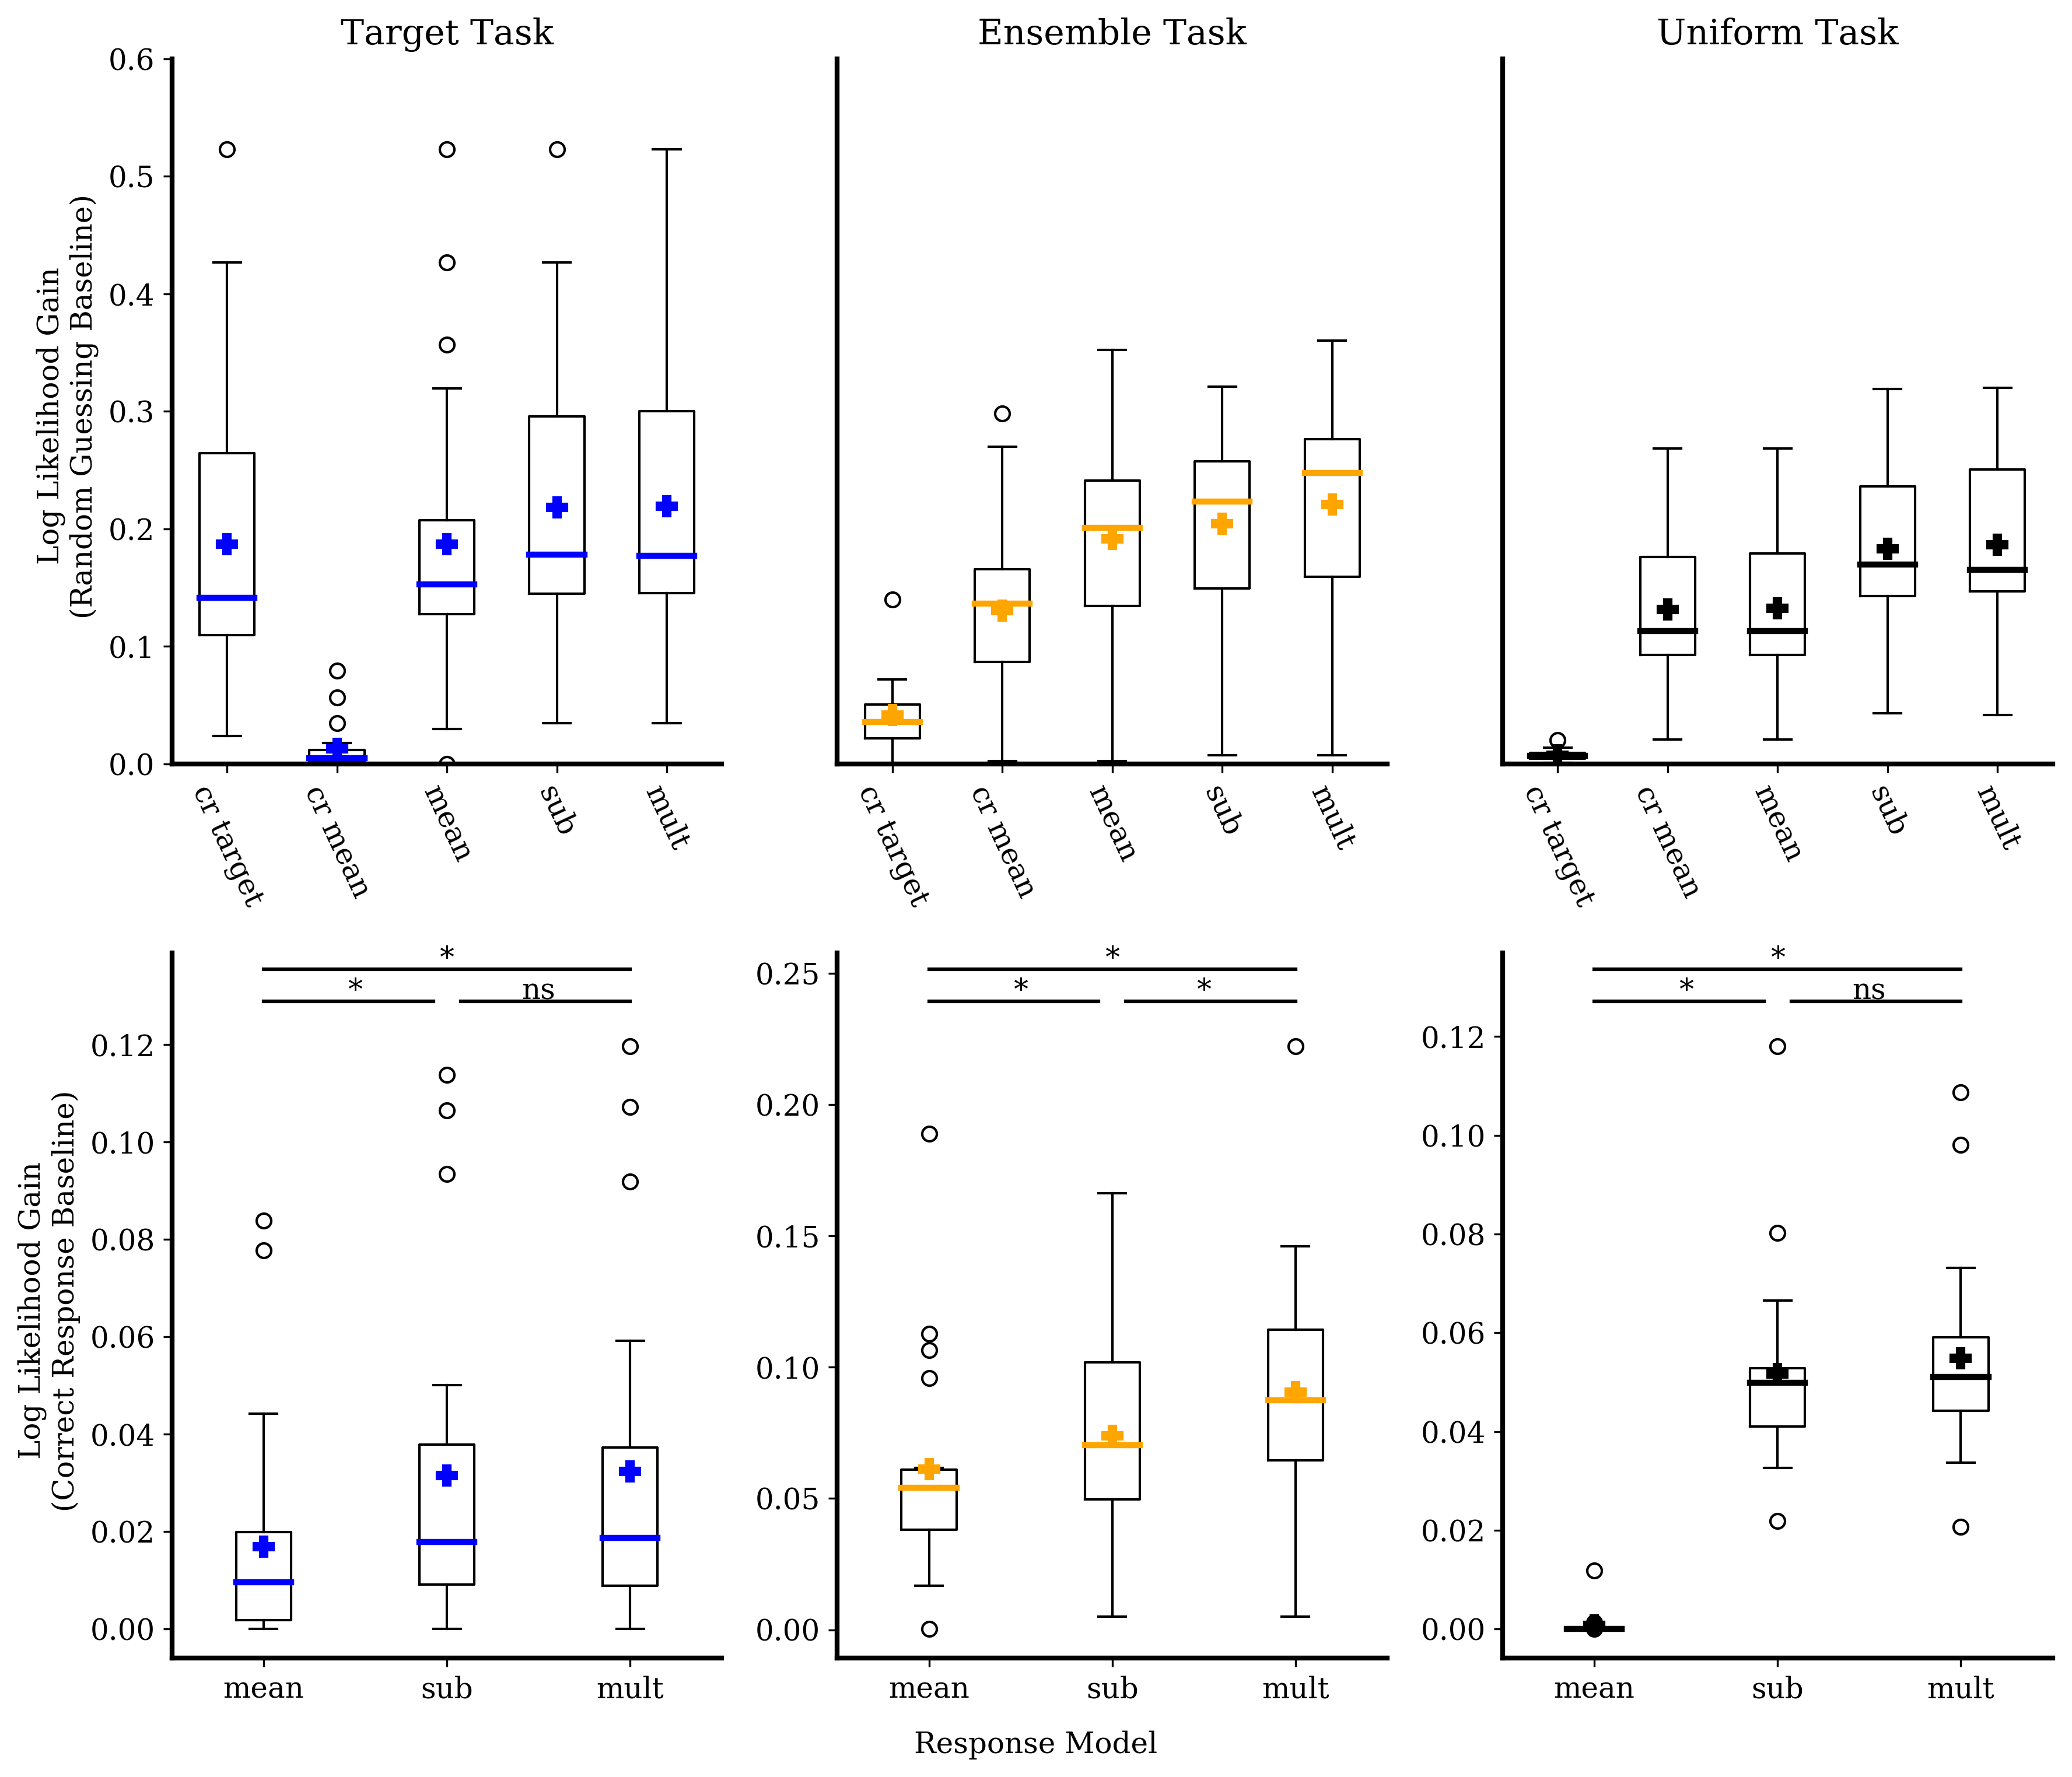

In [21]:
filenames = [
            ['total_model_fits/target_task_rc_target_4.pkl',
             'total_model_fits/target_task_rc_mean.pkl',
             'total_model_fits/target_task_mean.pkl',
             'total_model_fits/target_task_sub.pkl',
             'total_model_fits/target_task_mult.pkl'],
            ['total_model_fits/ensemble_task_rc_target.pkl',
             'total_model_fits/ensemble_task_rc_mean.pkl',
             'total_model_fits/ensemble_task_mean.pkl',
             'total_model_fits/ensemble_task_sub.pkl',
             'total_model_fits/ensemble_task_mult.pkl'],
            ['total_model_fits/uniform_task_rc_target.pkl',
             'total_model_fits/uniform_task_rc_mean.pkl',
             'total_model_fits/uniform_task_mean.pkl',
             'total_model_fits/uniform_task_sub.pkl',
             'total_model_fits/uniform_task_mult.pkl']
            ]

titles = ['Target Task', 'Ensemble Task', 'Uniform Task']
names = ['cr target','cr mean','mean','sub','mult']
markers = ['o','s','P','^', '.']
colors = ['blue', 'orange','black']

fig, ax = plt.subplots(2,len(titles), figsize=(12,10))

for f, files in enumerate(filenames):
    
    ax[0, f].set_title(titles[f])
    ax[0, f].set_ylim(0,.6)
#     ax[1, f].set_ylim(-.05,.25)
    ax[0, f].set_xticks(np.arange(len(names)))
    for i in [0,1]:
        ax[i, f].spines['bottom'].set_linewidth(2)
        ax[i, f].spines['left'].set_linewidth(2)
        ax[i, f].spines['top'].set_visible(False)
        ax[i, f].spines['right'].set_visible(False)
    
    ax[0,0].set_ylabel('Log Likelihood Gain \n (Random Guessing Baseline)')
    ax[1,0].set_ylabel('Log Likelihood Gain \n (Correct Response Baseline)')
        
    ax[0,1].set_yticks([])
    ax[0,2].set_yticks([])
    
    
    legend_handles = []
    data_array = []
    means = []
    sems = []
    meanprops = dict(marker='P',markersize=8,markerfacecolor=colors[f],markeredgecolor=colors[f])
    medianprops = dict(linestyle='-', linewidth=2.5, color=colors[f])
    for i, file in enumerate(files):
        data = pickle.load(open(file, 'rb'))
        l = [np.mean(np.log(a*.99+.005)-np.log(.5)) for a in data['likelihood']]
        data_array.append(l)
        means.append(np.mean(l))
        sems.append(np.std(l)/np.sqrt(len(l)))
        legend_handles.append(Line2D([0], [0],
                              marker=markers[i], color='k',
                              markersize=10, label=names[i], linestyle='none'))
        
#     ax[f].errorbar(np.arange(len(means)), means, sems, color=colors[f],
#                    marker=markers[i],markersize=20, linestyle='none')
    
    # guess baseline
    data_array = np.array(data_array).T
    
#     if f in [0,1]:
#         data_array = np.delete(data_array,3,axis=0)
    ax[0,f].boxplot(data_array, showmeans=True, medianprops=medianprops,meanprops=meanprops)
    ax[0,f].set_xticklabels(names, rotation=-65)
    
    # random/correct baseline
    if f == 0:
        data_array_rc = data_array[:,0,None]
    else:
        data_array_rc = data_array[:,1,None]
    
    data_array_rc_baseline = np.clip(data_array[:,2:] - data_array_rc, 0, None)
    ax[1,f].boxplot(data_array_rc_baseline, showmeans=True, medianprops=medianprops,
                    meanprops=meanprops,showfliers=True)
    ax[1,f].set_xticklabels(names[2:])
    
    t_mes, p_mes = scipy.stats.ttest_rel(data_array_rc_baseline[:,0], data_array_rc_baseline[:,1])
    t_smu, p_smu = scipy.stats.ttest_rel(data_array_rc_baseline[:,1], data_array_rc_baseline[:,2])
    t_memu, p_memu = scipy.stats.ttest_rel(data_array_rc_baseline[:,0], data_array_rc_baseline[:,2])
    
    print((t_mes, p_mes), (t_smu, p_smu), (t_memu, p_memu))
    
    
    y_lim = ax[1,f].get_ylim()
    y_range = y_lim[1] - y_lim[0]
    ax[1,f].set_ylim(y_lim[0], y_lim[1]+.1*y_range)
    ax[1,f].axhline(y_lim[1]+.025*y_range, xmin=1/6, xmax=.95/2, color='black')
    ax[1,f].axhline(y_lim[1]+.025*y_range, xmin=1.05/2, xmax=5/6, color='black')
    ax[1,f].axhline(y_lim[1]+.075*y_range, xmin=1/6, xmax=5/6, color='black')
    
    for p, x in zip([p_mes, p_smu, p_memu], [1.5,2.5,2]):
        if p<.05:
            string = '*'
        else:
            string = 'ns'
        if x == 2:
            scale = .078
        else:
            scale = .028
        ax[1,f].text(x, y_lim[1]+scale*y_range, string, ha='center')
    
fig.text(0.5, -.01, 'Response Model', ha='center');
fig.tight_layout()

In [22]:
fig.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')

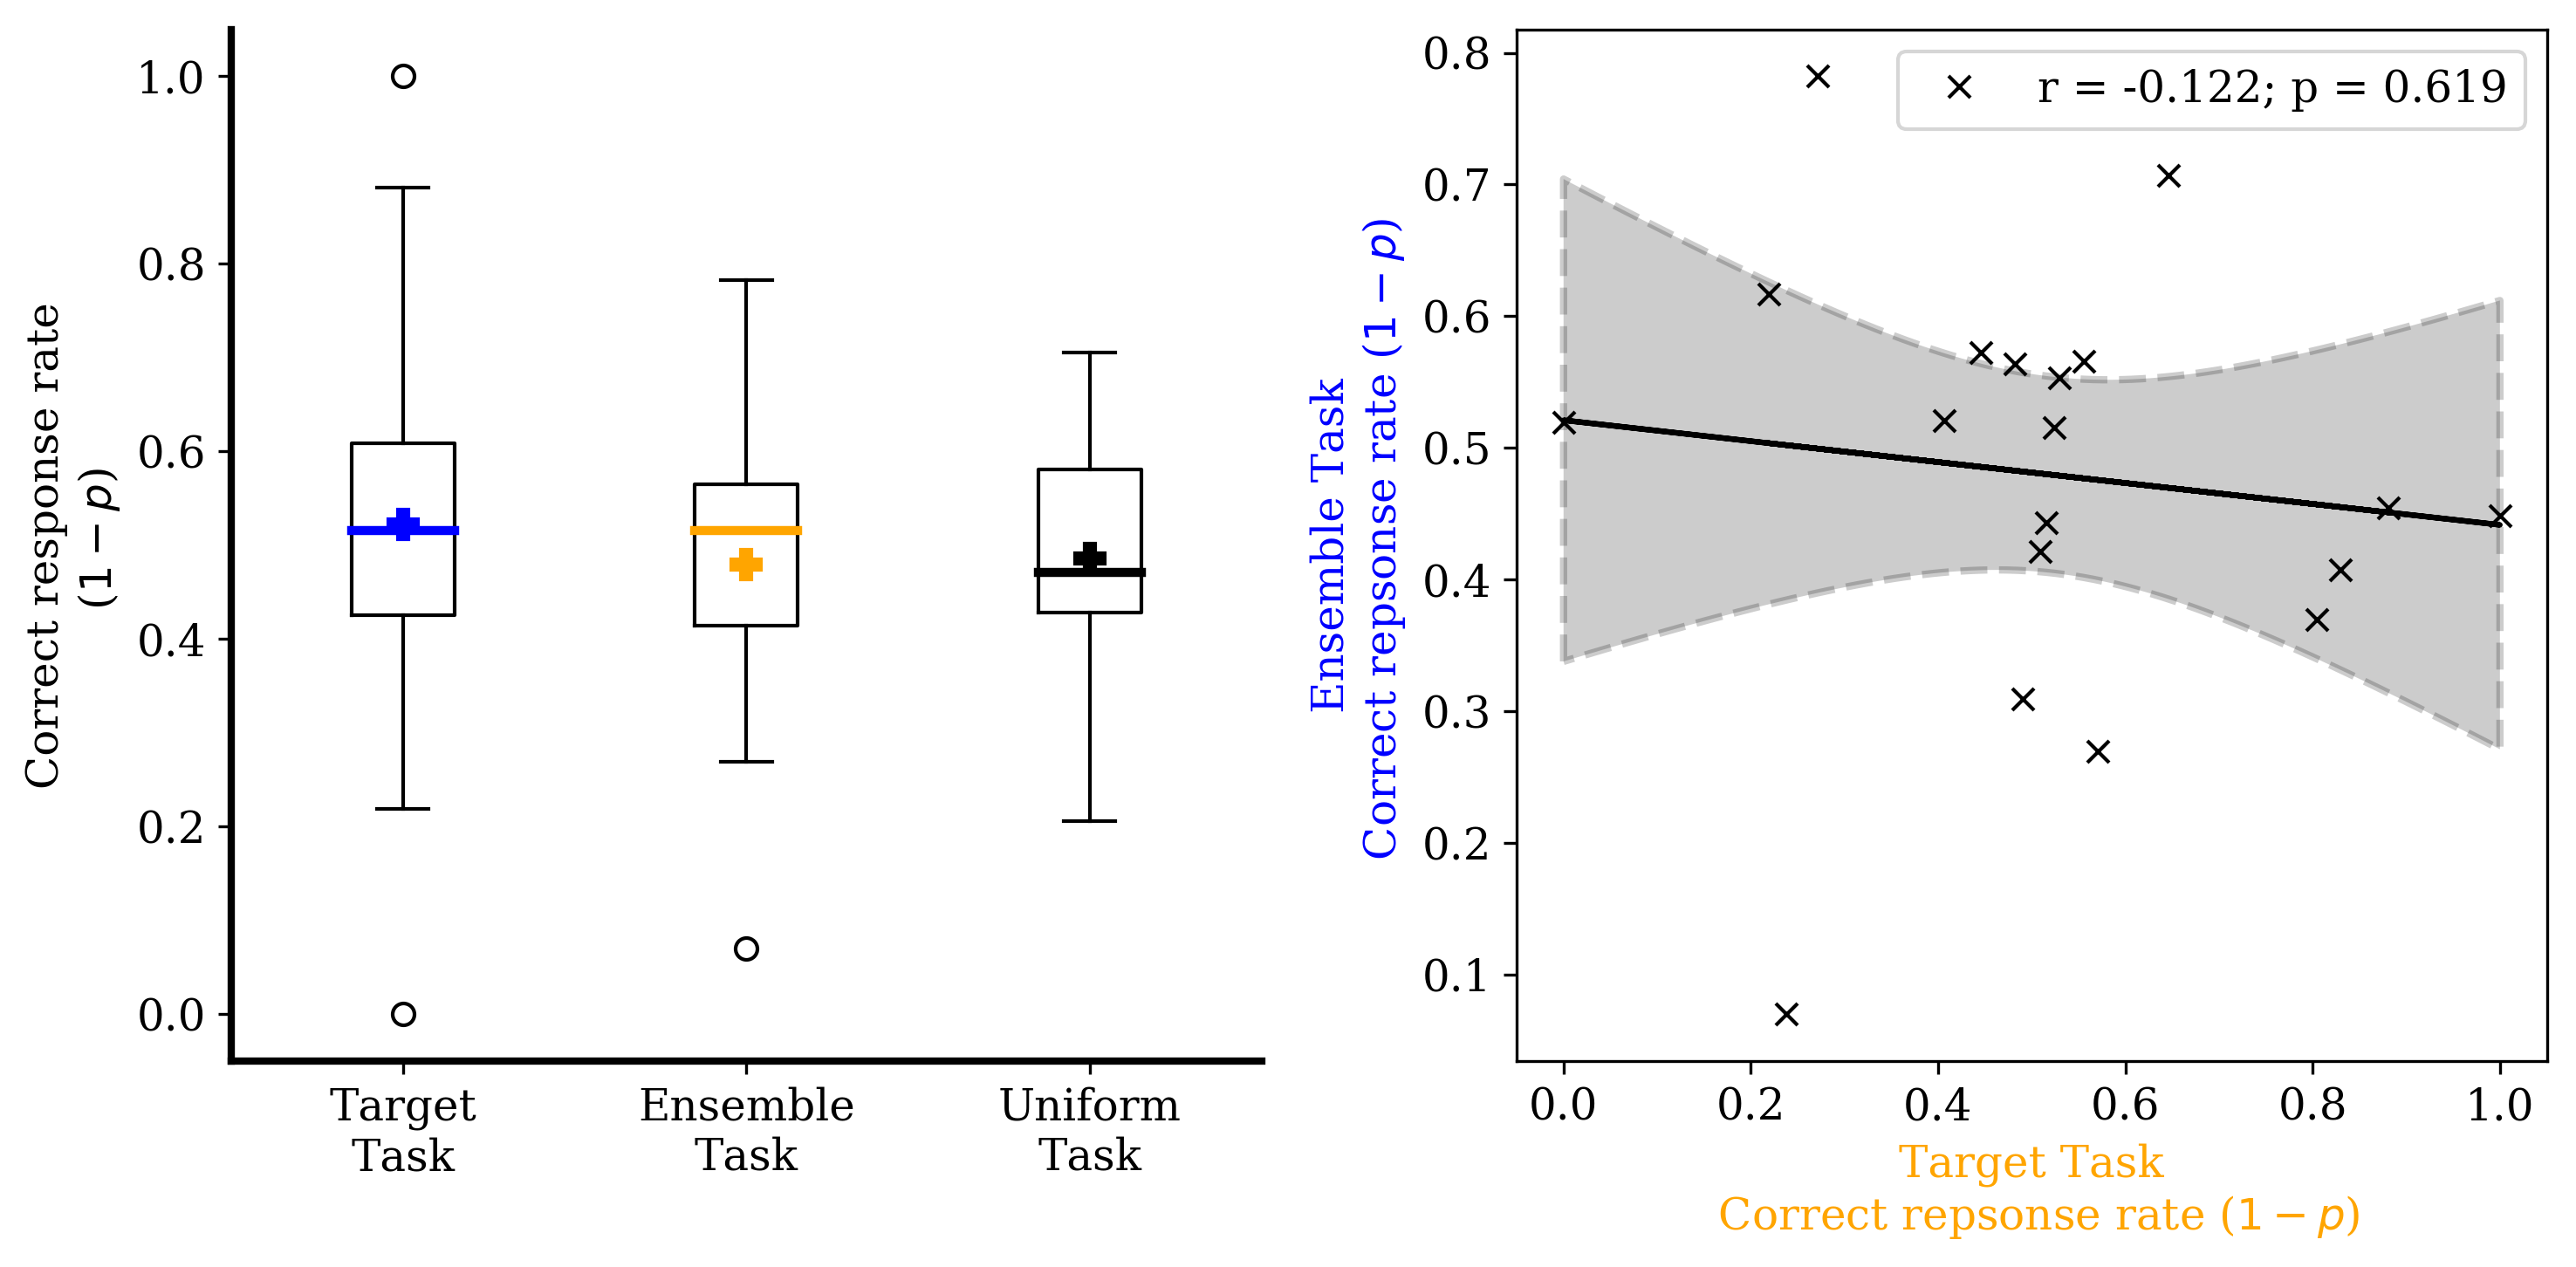

In [17]:
filenames = ['total_model_fits/target_task_rc_target.pkl',
              'total_model_fits/ensemble_task_rc_mean.pkl',
              'total_model_fits/uniform_task_rc_mean.pkl']

names = ['Target\nTask', 'Ensemble\nTask', 'Uniform\nTask']

fig, ax = plt.subplots(1,2, figsize=(10,5))
data_p = []
medianprops = dict(linestyle='-', linewidth=2.5)
meanprops = dict(marker='P', markersize=8)
for i , file in enumerate(filenames):
    data = pickle.load(open(file, 'rb'))
    # 1 - p
    p = np.squeeze(np.array(data['params']))
    p = np.clip(p, 0, 1)
    p = 1-p
    data_p.append(p)

boxplot = ax[0].boxplot(data_p, showmeans=True,medianprops=medianprops,meanprops=meanprops)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xticklabels(names)
ax[0].set_ylabel('Correct response rate\n ($1-p$)')

[m.set_markeredgecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange', 'black'])]
[m.set_markerfacecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange', 'black'])]
[m.set_color(c) for m, c in zip(boxplot['medians'], ['blue', 'orange', 'black'])]


corr_plot(ax[1], data_p[:2], p.size)
ax[1].set_ylabel('Ensemble Task\n Correct repsonse rate ($1-p$)', color='blue')
ax[1].set_xlabel('Target Task\n Correct repsonse rate ($1-p$)', color='orange')

fig.tight_layout()
    

In [18]:
fig.savefig('figures/correct_response_rate.png', dpi=300, bbox_inches='tight')

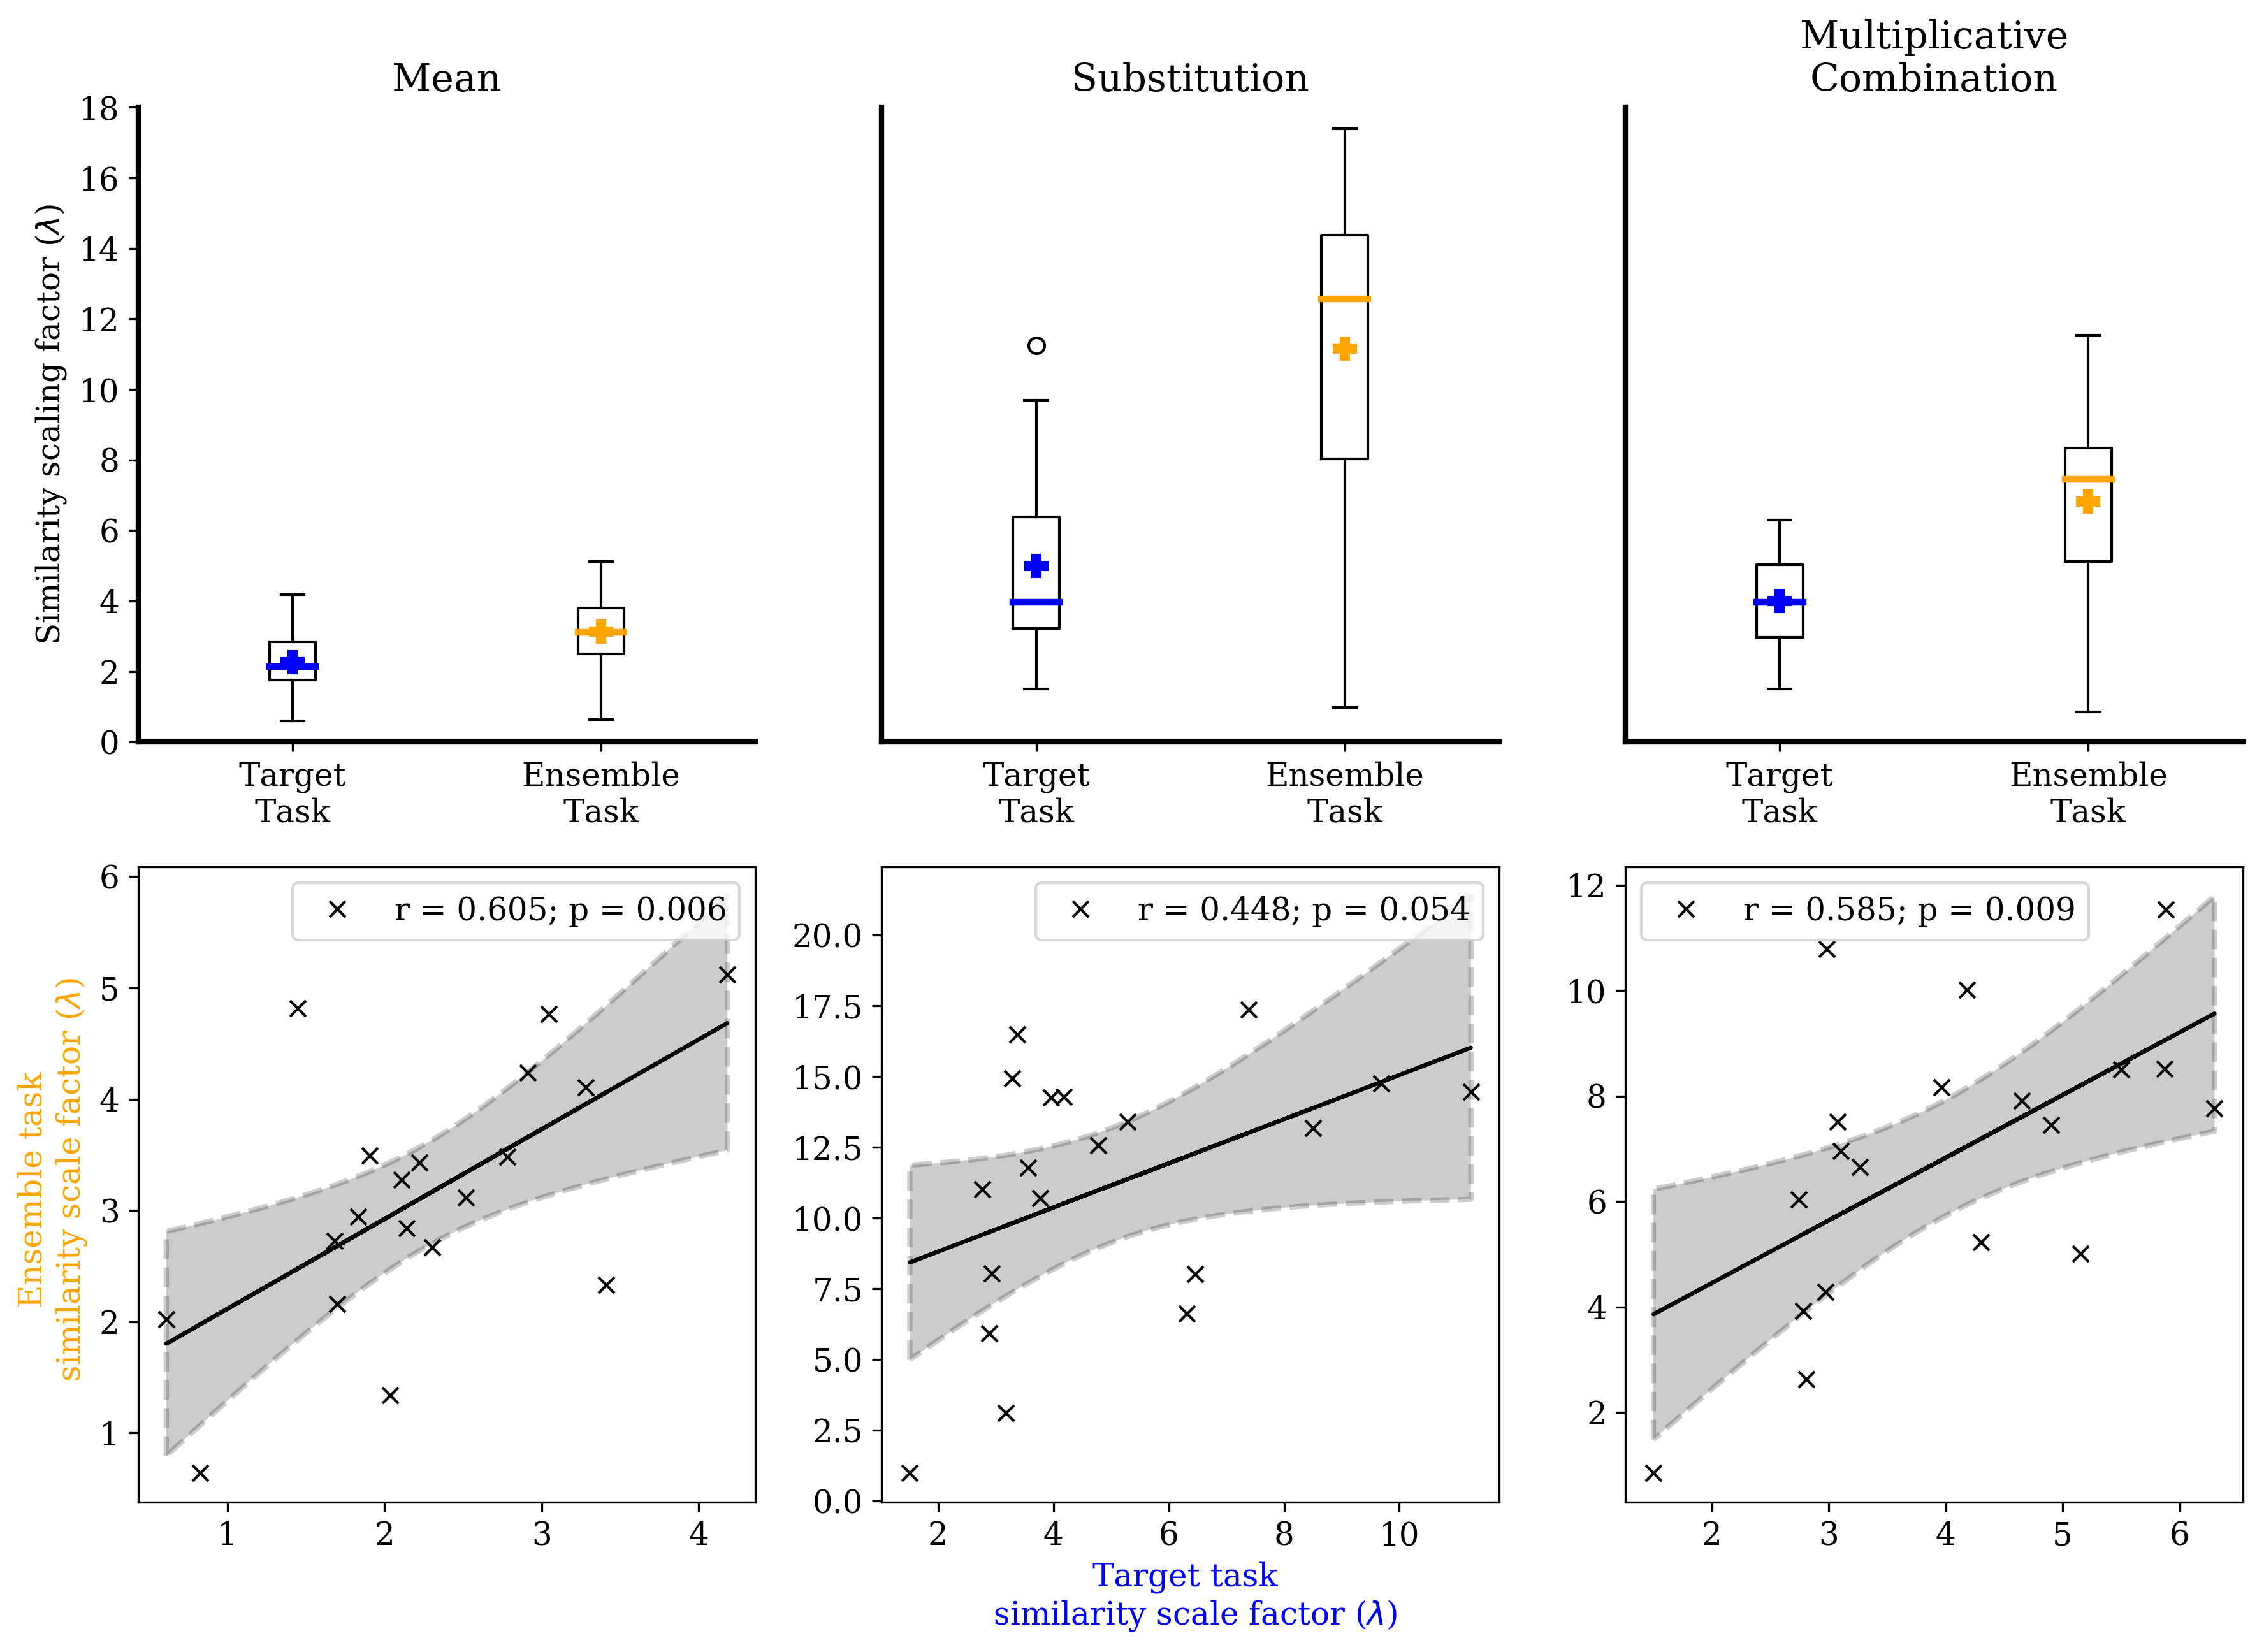

In [17]:
filenames = [['total_model_fits/target_task_mean.pkl',
              'total_model_fits/ensemble_task_mean.pkl'],
             ['total_model_fits/target_task_sub.pkl',
              'total_model_fits/ensemble_task_sub.pkl'],
             ['total_model_fits/target_task_mult.pkl',
              'total_model_fits/ensemble_task_mult.pkl']]


titles = ['Mean', 'Substitution', 'Multiplicative\nCombination']
names = ['Target\nTask', 'Ensemble\nTask']
colors = ['blue', 'orange']
markers = ['P', '^']

fig,ax = plt.subplots(2,3, figsize=(12,8.8))

for f, files in enumerate(filenames):
    ax[0, f].set_title(titles[f])
    ax[0, f].spines['bottom'].set_linewidth(2)
    ax[0, f].spines['left'].set_linewidth(2)
    ax[0, f].spines['top'].set_visible(False)
    ax[0, f].spines['right'].set_visible(False)
    ax[0,1].set_yticks([])
    ax[0,2].set_yticks([])

    ax[0,0].set_ylabel('Similarity scaling factor ($\lambda$)')
    ax[0,f].set_ylim(0,18)
    
    data_lambda = []
    medianprops = dict(linestyle='-', linewidth=2.5)
    meanprops = dict(marker='P', markersize=8)
    for i , file in enumerate(files):
        data = pickle.load(open(file, 'rb'))
        
        # orientation similarity scale factor
        lamb = np.squeeze(np.array([param[2] for param in data['params']]))
        data_lambda.append(lamb)

    boxplot = ax[0,f].boxplot(np.array(data_lambda).T, showmeans=True,
                              medianprops=medianprops,meanprops=meanprops)
    [m.set_color(c) for m, c in zip(boxplot['medians'], colors)]
    [m.set_markeredgecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange'])]
    [m.set_markerfacecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange'])]

    ax[0,f].set_xticklabels([])
    ax[0,f].set_xticklabels(names)
    
    corr_plot(ax[1,f], data_lambda, lamb.size)
    ax[1,0].set_ylabel('Ensemble task \n similarity scale factor ($\lambda$)',color='orange')
    ax[1,1].set_xlabel('Target task \n similarity scale factor ($\lambda$)', color='blue')
        

fig.tight_layout()
# fig.text(0.5, 0, 'Cue Validity', ha='center');

In [18]:
fig.savefig('figures/model_params_lambda.png', dpi=300, bbox_inches='tight')

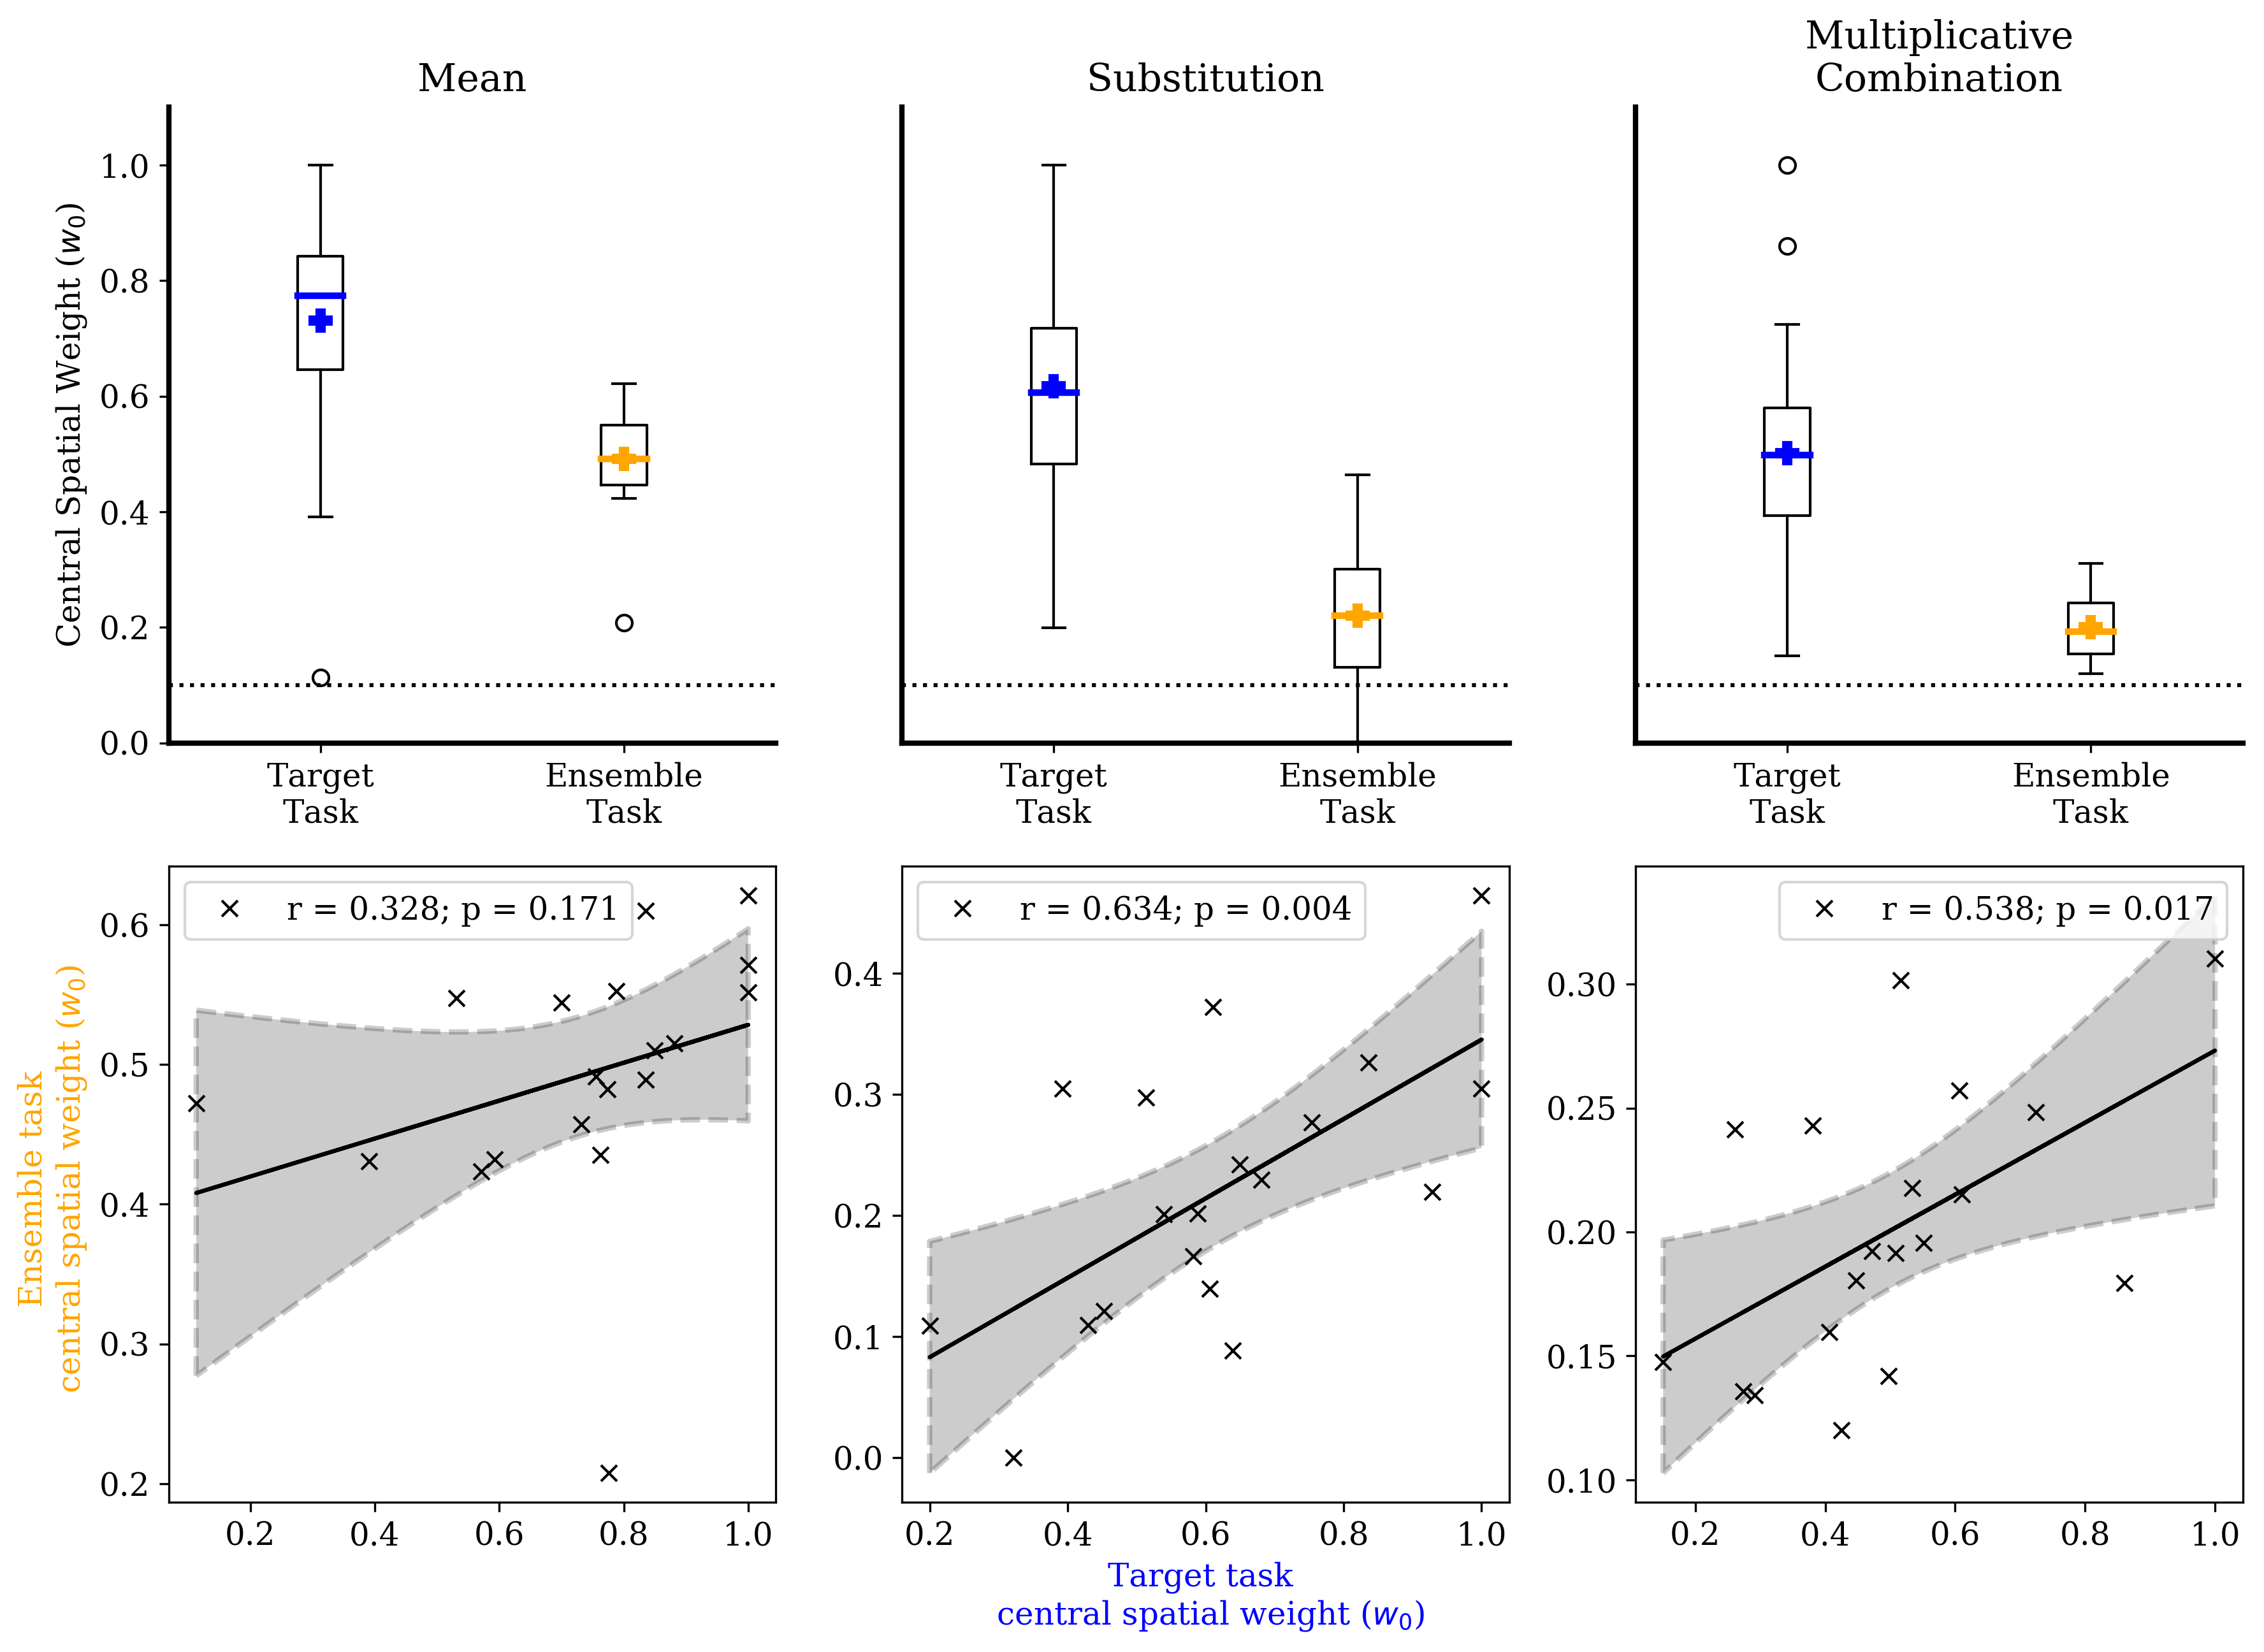

In [15]:
filenames = [['total_model_fits/target_task_mean.pkl',
              'total_model_fits/ensemble_task_mean.pkl'],
             ['total_model_fits/target_task_sub.pkl',
              'total_model_fits/ensemble_task_sub.pkl'],
             ['total_model_fits/target_task_mult.pkl',
              'total_model_fits/ensemble_task_mult.pkl']]


titles = ['Mean', 'Substitution', 'Multiplicative\nCombination']
names = ['Target\nTask', 'Ensemble\nTask']
colors = ['blue', 'orange']
markers = ['P', '^']

fig,ax = plt.subplots(2,3, figsize=(12,8.8))

for f, files in enumerate(filenames):
    ax[0, f].set_title(titles[f])
    ax[0, f].spines['bottom'].set_linewidth(2)
    ax[0, f].spines['left'].set_linewidth(2)
    ax[0, f].spines['top'].set_visible(False)
    ax[0, f].spines['right'].set_visible(False)
    ax[0,1].set_yticks([])
    ax[0,2].set_yticks([])

    ax[0,0].set_ylabel('Central Spatial Weight ($w_{0}$)')
    ax[0,f].set_ylim(0,1.1)
    
    data_s = []
    medianprops = dict(linestyle='-', linewidth=2.5)
    meanprops = dict(marker='P', markersize=8)
    for i , file in enumerate(files):
        data = pickle.load(open(file, 'rb'))
        
        # get just the target's spatial weight
        s = np.squeeze(np.array([param[1] for param in data['params']]))
        s = np.clip(s,0,None)
        s = s / np.sum(s,axis=1).reshape(19,1)
        s = s[:,0]
        data_s.append(s)

    boxplot = ax[0,f].boxplot(np.array(data_s).T, showmeans=True,
                              medianprops=medianprops,meanprops=meanprops)
    [m.set_color(c) for m, c in zip(boxplot['medians'], colors)]
    [m.set_markeredgecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange'])]
    [m.set_markerfacecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange'])]

    ax[0,f].set_xticklabels([])
    ax[0,f].set_xticklabels(names)
    ax[0,f].axhline(.1, color='black', linestyle=':')

    
    corr_plot(ax[1,f], data_s, s.size)
    ax[1,0].set_ylabel('Ensemble task \n central spatial weight ($w_{0}$)',color='orange')
    ax[1,1].set_xlabel('Target task \n central spatial weight ($w_{0}$)', color='blue')
    
        

fig.tight_layout()
# fig.text(0.5, 0, 'Cue Validity', ha='center');

In [16]:
fig.savefig('figures/model_params_w0.png', dpi=300, bbox_inches='tight')

In [19]:
def ellipse(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    e = fit_ellipse(x,y)
    if len(e) != 0:
        return x,y,cart_to_pol(e)
    else:
        return None,None,None
    
def rt_ratio(ex,ey,cx,cy):
    # radial
    ex_left = ex[ex < cx]
    ey_left = ey[ex < cx]
    ex_right = ex[ex > cx]
    ey_right = ey[ex > cx]
    x_dist = ex_right[np.argmin(ey_right - cy)] - ex_left[np.argmin(ey_left - cy)]
    
    # tangential   
    ex_up = ex[ey < cy]
    ey_up = ey[ey < cy]
    ex_down = ex[ey > cy]
    ey_down = ey[ey > cy]
    y_dist = ey_down[np.argmin(ex_down - cx)] - ey_up[np.argmin(ex_up - cx)]
    
    return x_dist / y_dist
    

(0.7760500482193508, 0.4497833216303724) (3.8535263934273063, 0.001163929834883469)
(2.8207139771825465, 0.012908496954853247) (0.3439725223894584, 0.734852525295645)
(1.1935294372205814, 0.253988517561567) (2.050812665591069, 0.05513374953145753)
(2.5126963892642618, 0.025959481006959703) (2.383256709307137, 0.028384696171492314)
(1.097497462938602, 0.28866685906163814) (3.3292099385178195, 0.003732578134013623)
(4.046460862053544, 0.0009360342459556373) (0.7344789992831299, 0.4721175360692269)


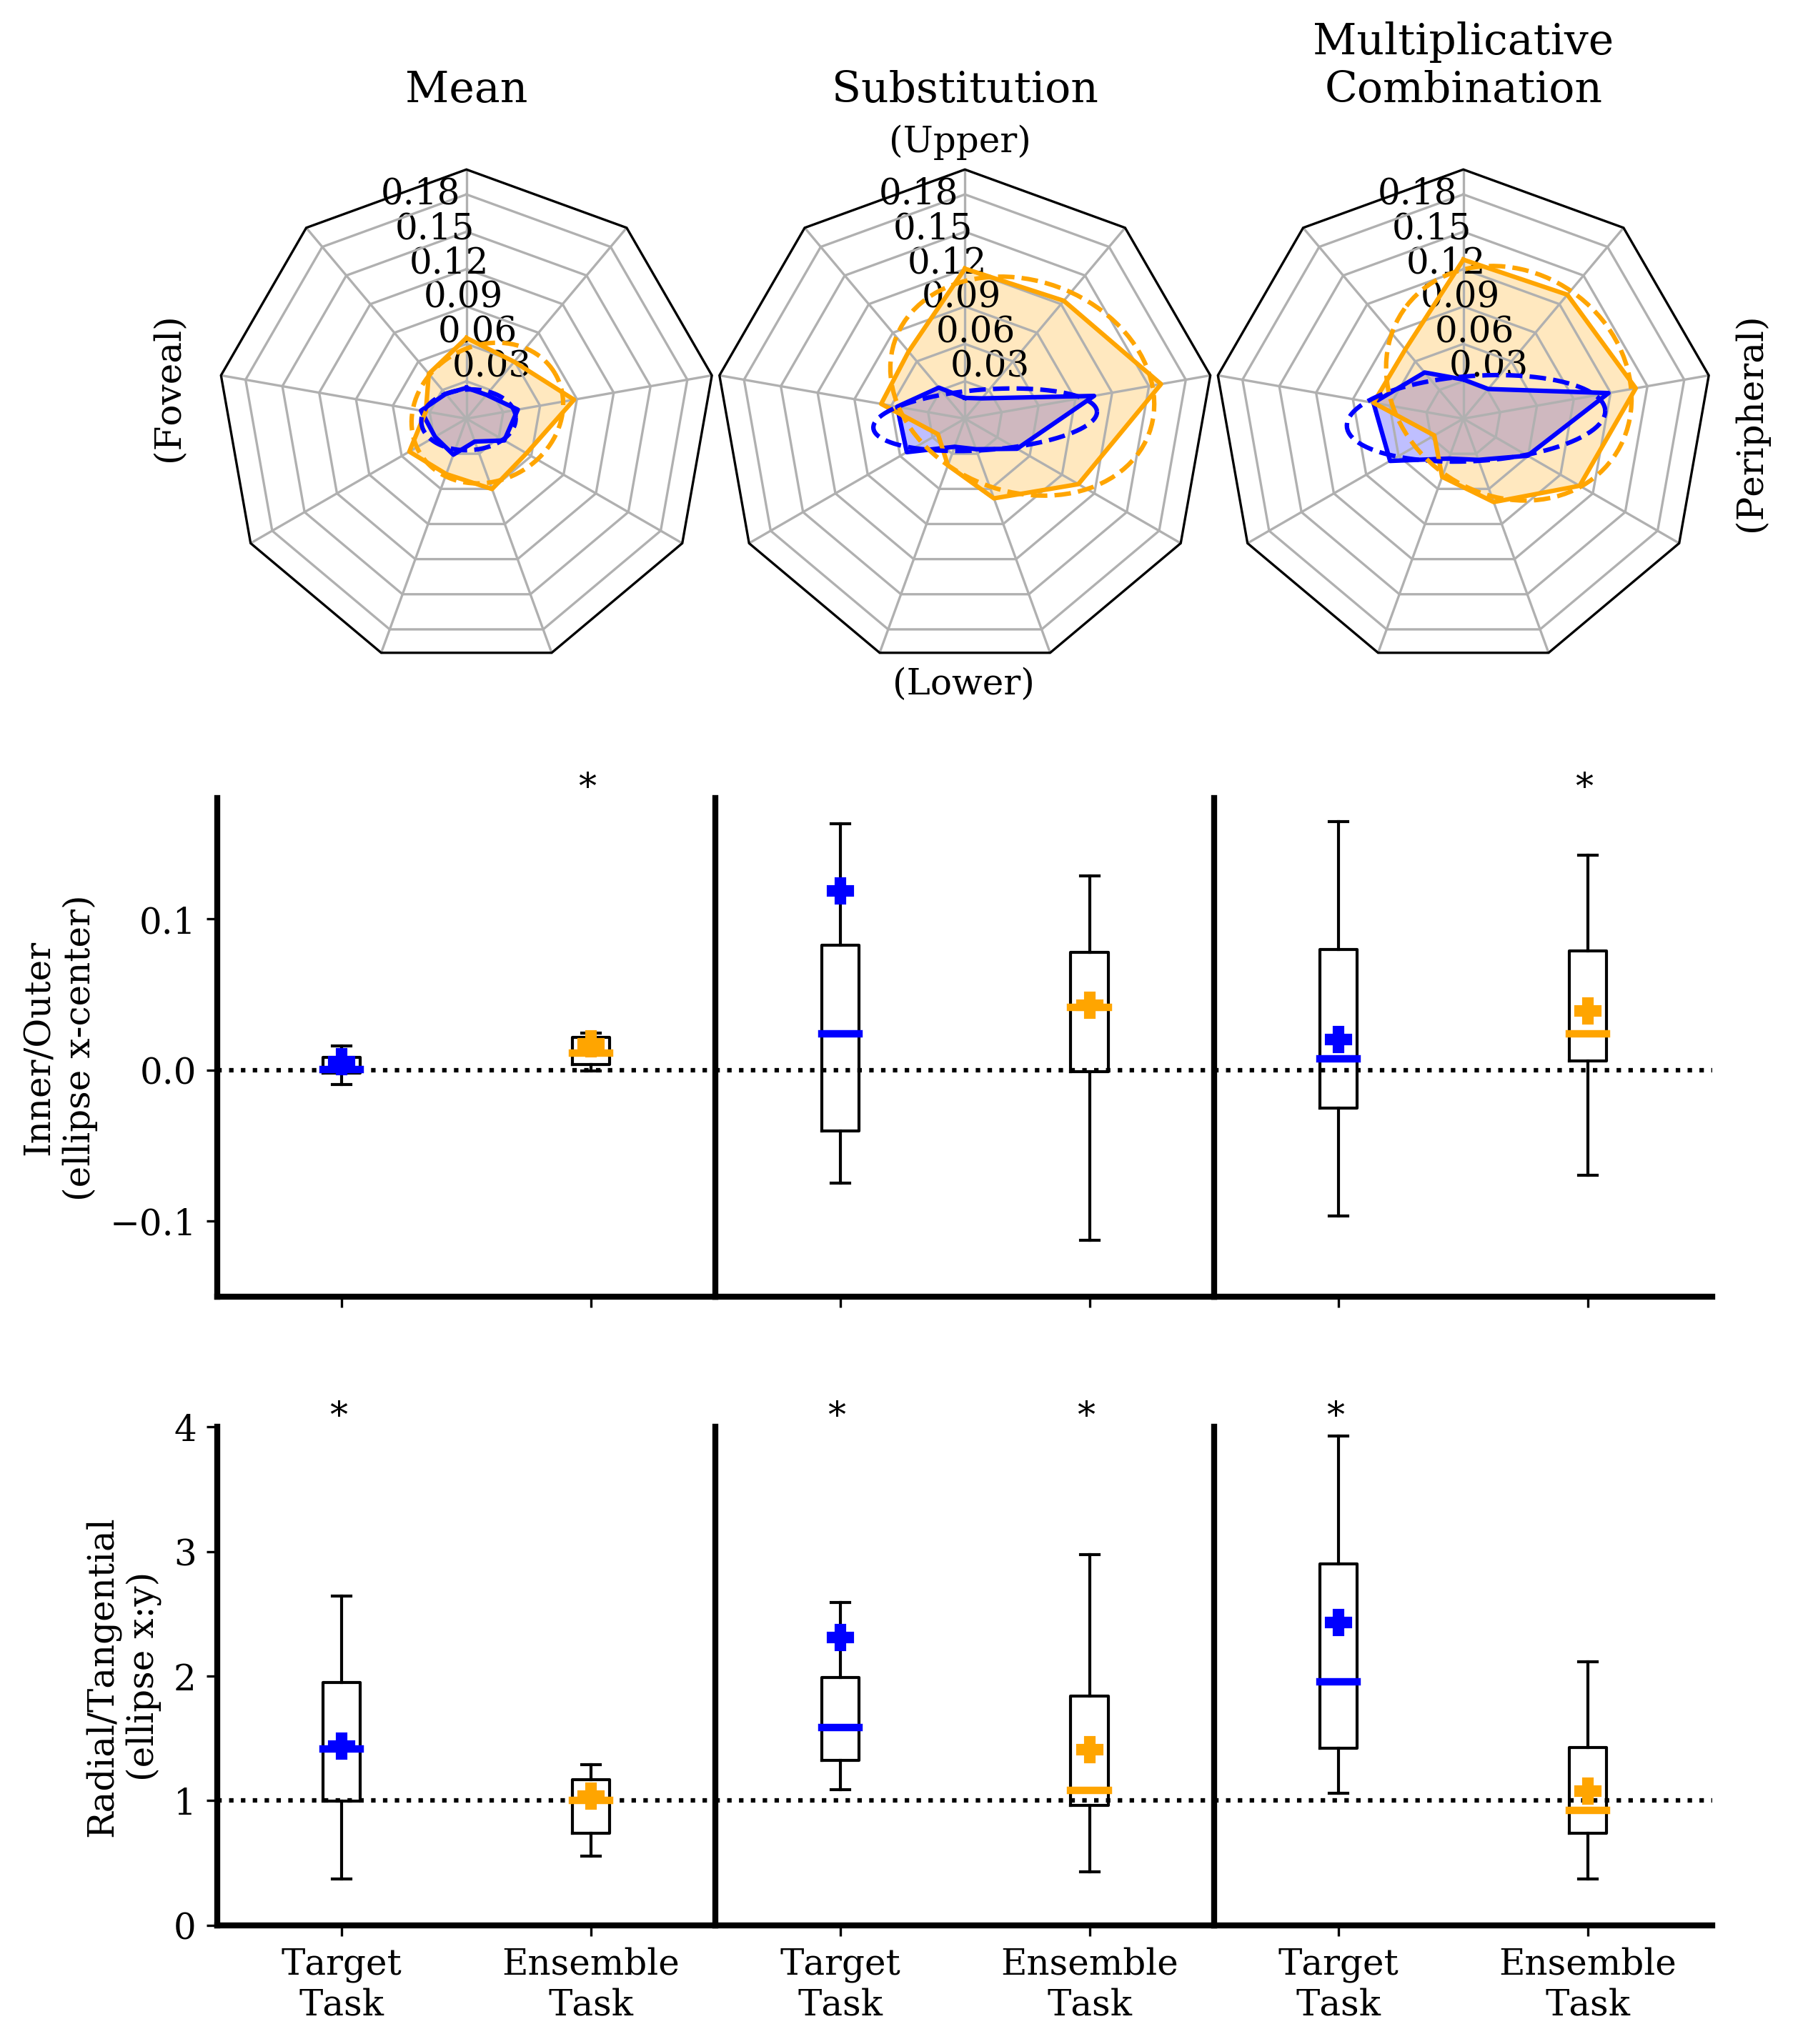

In [20]:
filenames = [['total_model_fits/target_task_mean.pkl',
              'total_model_fits/ensemble_task_mean.pkl'],
             ['total_model_fits/target_task_sub.pkl',
              'total_model_fits/ensemble_task_sub.pkl'],
             ['total_model_fits/target_task_mult.pkl',
              'total_model_fits/ensemble_task_mult.pkl']]

theta = radar_factory(9, frame='polygon')

fig, ax= plt.subplots(figsize=(9, 11), nrows=3, ncols=3,
                        subplot_kw=dict(projection='radar'))
# fig, ax = plt.subplots(1,3, figsize=(15,5))

fig.subplots_adjust(wspace=0, hspace=0, top=0.85, bottom=0.05)

colors = ['blue', 'orange']
titles = ['Mean', 'Substitution', "Multiplicative\nCombination"]
task_type = ["Target\nTask", "Ensemble\nTask"]

for f, files in enumerate(filenames):
    legend_handles=[]
    cx_array = []; rt_ratio_array = []
    sub_tracker = []
    for i, file in enumerate(files):
        data = pickle.load(open(file, 'rb'))
        s = np.squeeze(np.array([param[1] for param in data['params']]))
        s = np.clip(s,0,None)
        s = s / np.sum(s,axis=1).reshape(19,1)
        
        cx = []; rt = []
        for sub_idx, s_sub in enumerate(s[:,1:]):
            try:
                x,y,e = ellipse(s_sub, theta+np.pi/2)
            except:
                continue
                
            if e is not None:
                x2,y2 = get_ellipse_pts(e)
                rt.append(rt_ratio(x2,y2,e[0],e[1]))
                cx.append(e[0])

        cx_array.append(cx); rt_ratio_array.append(rt)
        # get mean ellipse
        d = np.mean(s[:,1:],axis=0)

        ax[0,f].set_rgrids([0.03, 0.06, 0.09, 0.12,.15,.18])
        ax[0,f].plot(theta, d, color=colors[i])
        ax[0,f].set_title(titles[f],position=(0.5, 1.1))
        ax[0,f].fill(theta, d, facecolor=colors[i], alpha=0.25, label='_nolegend_')
        ax[0,f].set_ylim(0,.2)
        ax[0,f].set_varlabels([None,]*9)
        
        ax_cart = fig.add_axes(ax[0,f].get_position(), frameon=False)        
        x,y,e = ellipse(d, theta+np.pi/2)
        x2,y2 = get_ellipse_pts(e)
        ax_cart.plot(x2,y2,'--',color=colors[i])
        ax_cart.set_xlim(-.2,.2)
        ax_cart.set_ylim(-.2,.2)
        ax_cart.set_xticks([])
        ax_cart.set_yticks([])

        legend_handles.append(Line2D([0], [0], color=colors[i],
                 label=task_type[i],lw=4))
        
    for i, d in enumerate([cx_array, rt_ratio_array]):
        ax[i+1,f].axis('off')
        ax_cart = fig.add_axes(ax[i+1,f].get_position(), frameon=True) 
        boxplot = ax_cart.boxplot(d, showmeans=True,medianprops=medianprops,
                                  meanprops=meanprops,showfliers=False)
        [m.set_color(c) for m, c in zip(boxplot['medians'], colors)]
        [m.set_markeredgecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange'])]
        [m.set_markerfacecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange'])]
        ax_cart.spines['bottom'].set_linewidth(2)
        ax_cart.spines['left'].set_linewidth(2)
        ax_cart.spines['top'].set_visible(False)
        ax_cart.spines['right'].set_visible(False)
        if i == 1:
            ax_cart.set_xticklabels(task_type)
            ax_cart.set_ylim(0,4)
            ax_cart.axhline(1, color='black', linestyle=':')
            t_t, p_t = scipy.stats.ttest_1samp(d[0], 1)
            t_e, p_e = scipy.stats.ttest_1samp(d[1], 1)
            for p,x in zip([p_t, p_e], [1,2]):
                if p<.05:
                    ax_cart.text(x-.05, ax_cart.get_ylim()[1], '*')
        else:
            ax_cart.set_xticklabels([])
            ax_cart.set_ylim(-.15,.18)
            ax_cart.axhline(0, color='black', linestyle=':')
            t_t, p_t = scipy.stats.ttest_1samp(d[0], 0)
            t_e, p_e = scipy.stats.ttest_1samp(d[1], 0)
            for p,x in zip([p_t, p_e], [1,2]):
                if p<.05:
                    ax_cart.text(x-.05, ax_cart.get_ylim()[1], '*')
                    
        print((t_t,p_t),(t_e, p_e))
        if i == 0 and f == 0:
            ax_cart.set_ylabel('Inner/Outer\n(ellipse x-center)')
        elif i==1 and f==0:
            ax_cart.set_ylabel('Radial/Tangential\n(ellipse x:y)')
        else:
            ax_cart.set_yticks([])
        
fig.text(.51, .83, '(Upper)', ha='center', rotation=0);
fig.text(.512, .60, '(Lower)', ha='center', rotation=0);
fig.text(.1, .75, '(Foveal)', ha='center', rotation=90);
fig.text(.92, .75, '(Peripheral)', ha='center', rotation=90);

# fig.tight_layout()

In [ ]:
fig.savefig('figures/spatial_weights.png', dpi=300, bbox_inches='tight')

In [ ]:
print((theta+np.pi/2)*(180/np.pi)%360)
np.cos(theta +np.pi/2)
np.sin

**Plots**

In [ ]:
filenames = [
            ['mean_model_fits/target_task_rc_target.pkl',
             'mean_model_fits/target_task_rc_mean.pkl',
             'mean_model_fits/target_task_sub.pkl',
             'mean_model_fits/target_task_mult.pkl'],
            ['mean_model_fits/ensemble_task_rc_target.pkl',
             'mean_model_fits/ensemble_task_rc_mean.pkl',
             'mean_model_fits/ensemble_task_sub.pkl',
             'mean_model_fits/ensemble_task_mult.pkl']
            ]

titles = ['Target Task', 'Ensemble Task']
names = ['rc target','rc mean', 'sub','mult']
markers = ['o','s','P','^']
colors = ['blue', 'orange']


step= .1
n_steps = len(filenames[0])/2 - 1

fig, ax = plt.subplots(1,2, figsize=(10,5))

for f, files in enumerate(filenames):
    ax[f].set_title(titles[f])
    ax[f].set_ylim(0,.35)
    ax[f].set_xticks(np.arange(4))
    ax[f].set_xticklabels(cond_keys)
    ax[0].set_ylabel('Log Likelihood (gain)')
    
    legend_handles = []
    for i, file in enumerate(files):
        data = pickle.load(open(file, 'rb'))
        means = []
        sems = []
        for key in cond_keys:
            l = [np.mean(np.log(a*.99+.005)-np.log(.5)) for a in data[key]['likelihood']]
            means.append(np.mean(l))
            sems.append(np.std(l)/np.sqrt(len(l)))
        if i <= n_steps:
            ax[f].errorbar(np.arange(4)-step*((n_steps+1)-(i%(n_steps+1))),means,sems, color=colors[f],
                         marker=markers[i],markersize=10, linestyle='none')
        else:
            ax[f].errorbar(np.arange(4)+ step*(i%(n_steps+1)),means,sems, color=colors[f],
                         marker=markers[i],markersize=10, linestyle='none')

            
        legend_handles.append(Line2D([0], [0],
                                     marker=markers[i], color='k',
                                     markersize=10, label=names[i], linestyle='none'))




In [ ]:
filenames = [
            ['mean_model_fits/target_task_rc_target.pkl',
             'mean_model_fits/target_task_rc_mean.pkl'],
            ['mean_model_fits/ensemble_task_rc_target.pkl',
            'mean_model_fits/ensemble_task_rc_mean.pkl']
            ]

titles = ['Target Task', 'Ensemble Task']
names = ['Target', 'Arithmetic mean']
colors = ['blue', 'orange']
markers = ['o', 's']

fig, ax = plt.subplots(1,2, figsize=(10,5))
for f, files in enumerate(filenames):
    ax[f].set_title(titles[f])
    ax[f].set_xticks(np.arange(4))
    ax[f].set_xticklabels(cond_keys)
    ax[0].set_ylabel('Probability of getting a correct response \n (1 - p)')
    ax[f].set_ylim(0,.7)

    legend_handles = []
    for i, file in enumerate(files):
        means = []
        sems = []
        for key in cond_keys:
            data = pickle.load(open(file, 'rb'))
            p = 1-np.array(data[key]['params'])
            means.append(np.mean(p))
            sems.append(np.std(p)/np.sqrt(len(p)))
        ax[f].errorbar(np.arange(4),means,sems, color=colors[f],marker=markers[i],markersize=10,
                       linestyle='none')
        
        legend_handles.append(Line2D([0], [0],
                             marker=markers[i], color='k',
                             markersize=10, label=names[i], linestyle='none'))

ax[f].legend(handles=legend_handles, bbox_to_anchor=(1.55, 1))    
fig.text(0.5, 0, 'Cue Validity', ha='center');

In [ ]:
filenames = [['mean_model_fits/target_task_sub.pkl',
              'mean_model_fits/ensemble_task_sub.pkl'],
             ['mean_model_fits/target_task_mult.pkl',
              'mean_model_fits/ensemble_task_mult.pkl']]


titles = ['Substitution', 'Multiplicative Combination']
names = ['Target Task', 'Ensemble Task']
colors = ['blue', 'orange']
markers = ['P', '^']

fig,ax = plt.subplots(1,2, figsize=(10,5))

for f, files in enumerate(filenames):
    ax[f].set_title(titles[f])
    ax[f].set_xticks(np.arange(4))
    ax[f].set_xticklabels(cond_keys)
    ax[0].set_ylabel('Central Spatial Weight ($w_{0}$)')
    ax[f].set_ylim(0,.75)
    
    legend_handles = []
    for i , file in enumerate(files):
        means = []
        sems = []
        for key in cond_keys:
            data = pickle.load(open(file, 'rb'))

            # get just the target's spatial weight
            s = np.squeeze(np.array([param[1] for param in data[key]['params']]))
            s = s / np.sum(s,axis=1).reshape(19,1)
            s = s[:,0]

            means.append(np.mean(s))
            sems.append(np.std(s)/np.sqrt(len(s)))

        ax[f].errorbar(np.arange(4),means,sems,color=colors[i],
                       marker=markers[f],markersize=12, linestyle='none')
        
        legend_handles.append(Line2D([0], [0], color=colors[i],
                     label=names[i],lw=5))
        

ax[f].legend(handles=legend_handles, bbox_to_anchor=(1.6, 1))    
fig.text(0.5, 0, 'Cue Validity', ha='center');

2.3488914275693014 0.03044922306626103
3.711379912954966 0.0015976477027416793


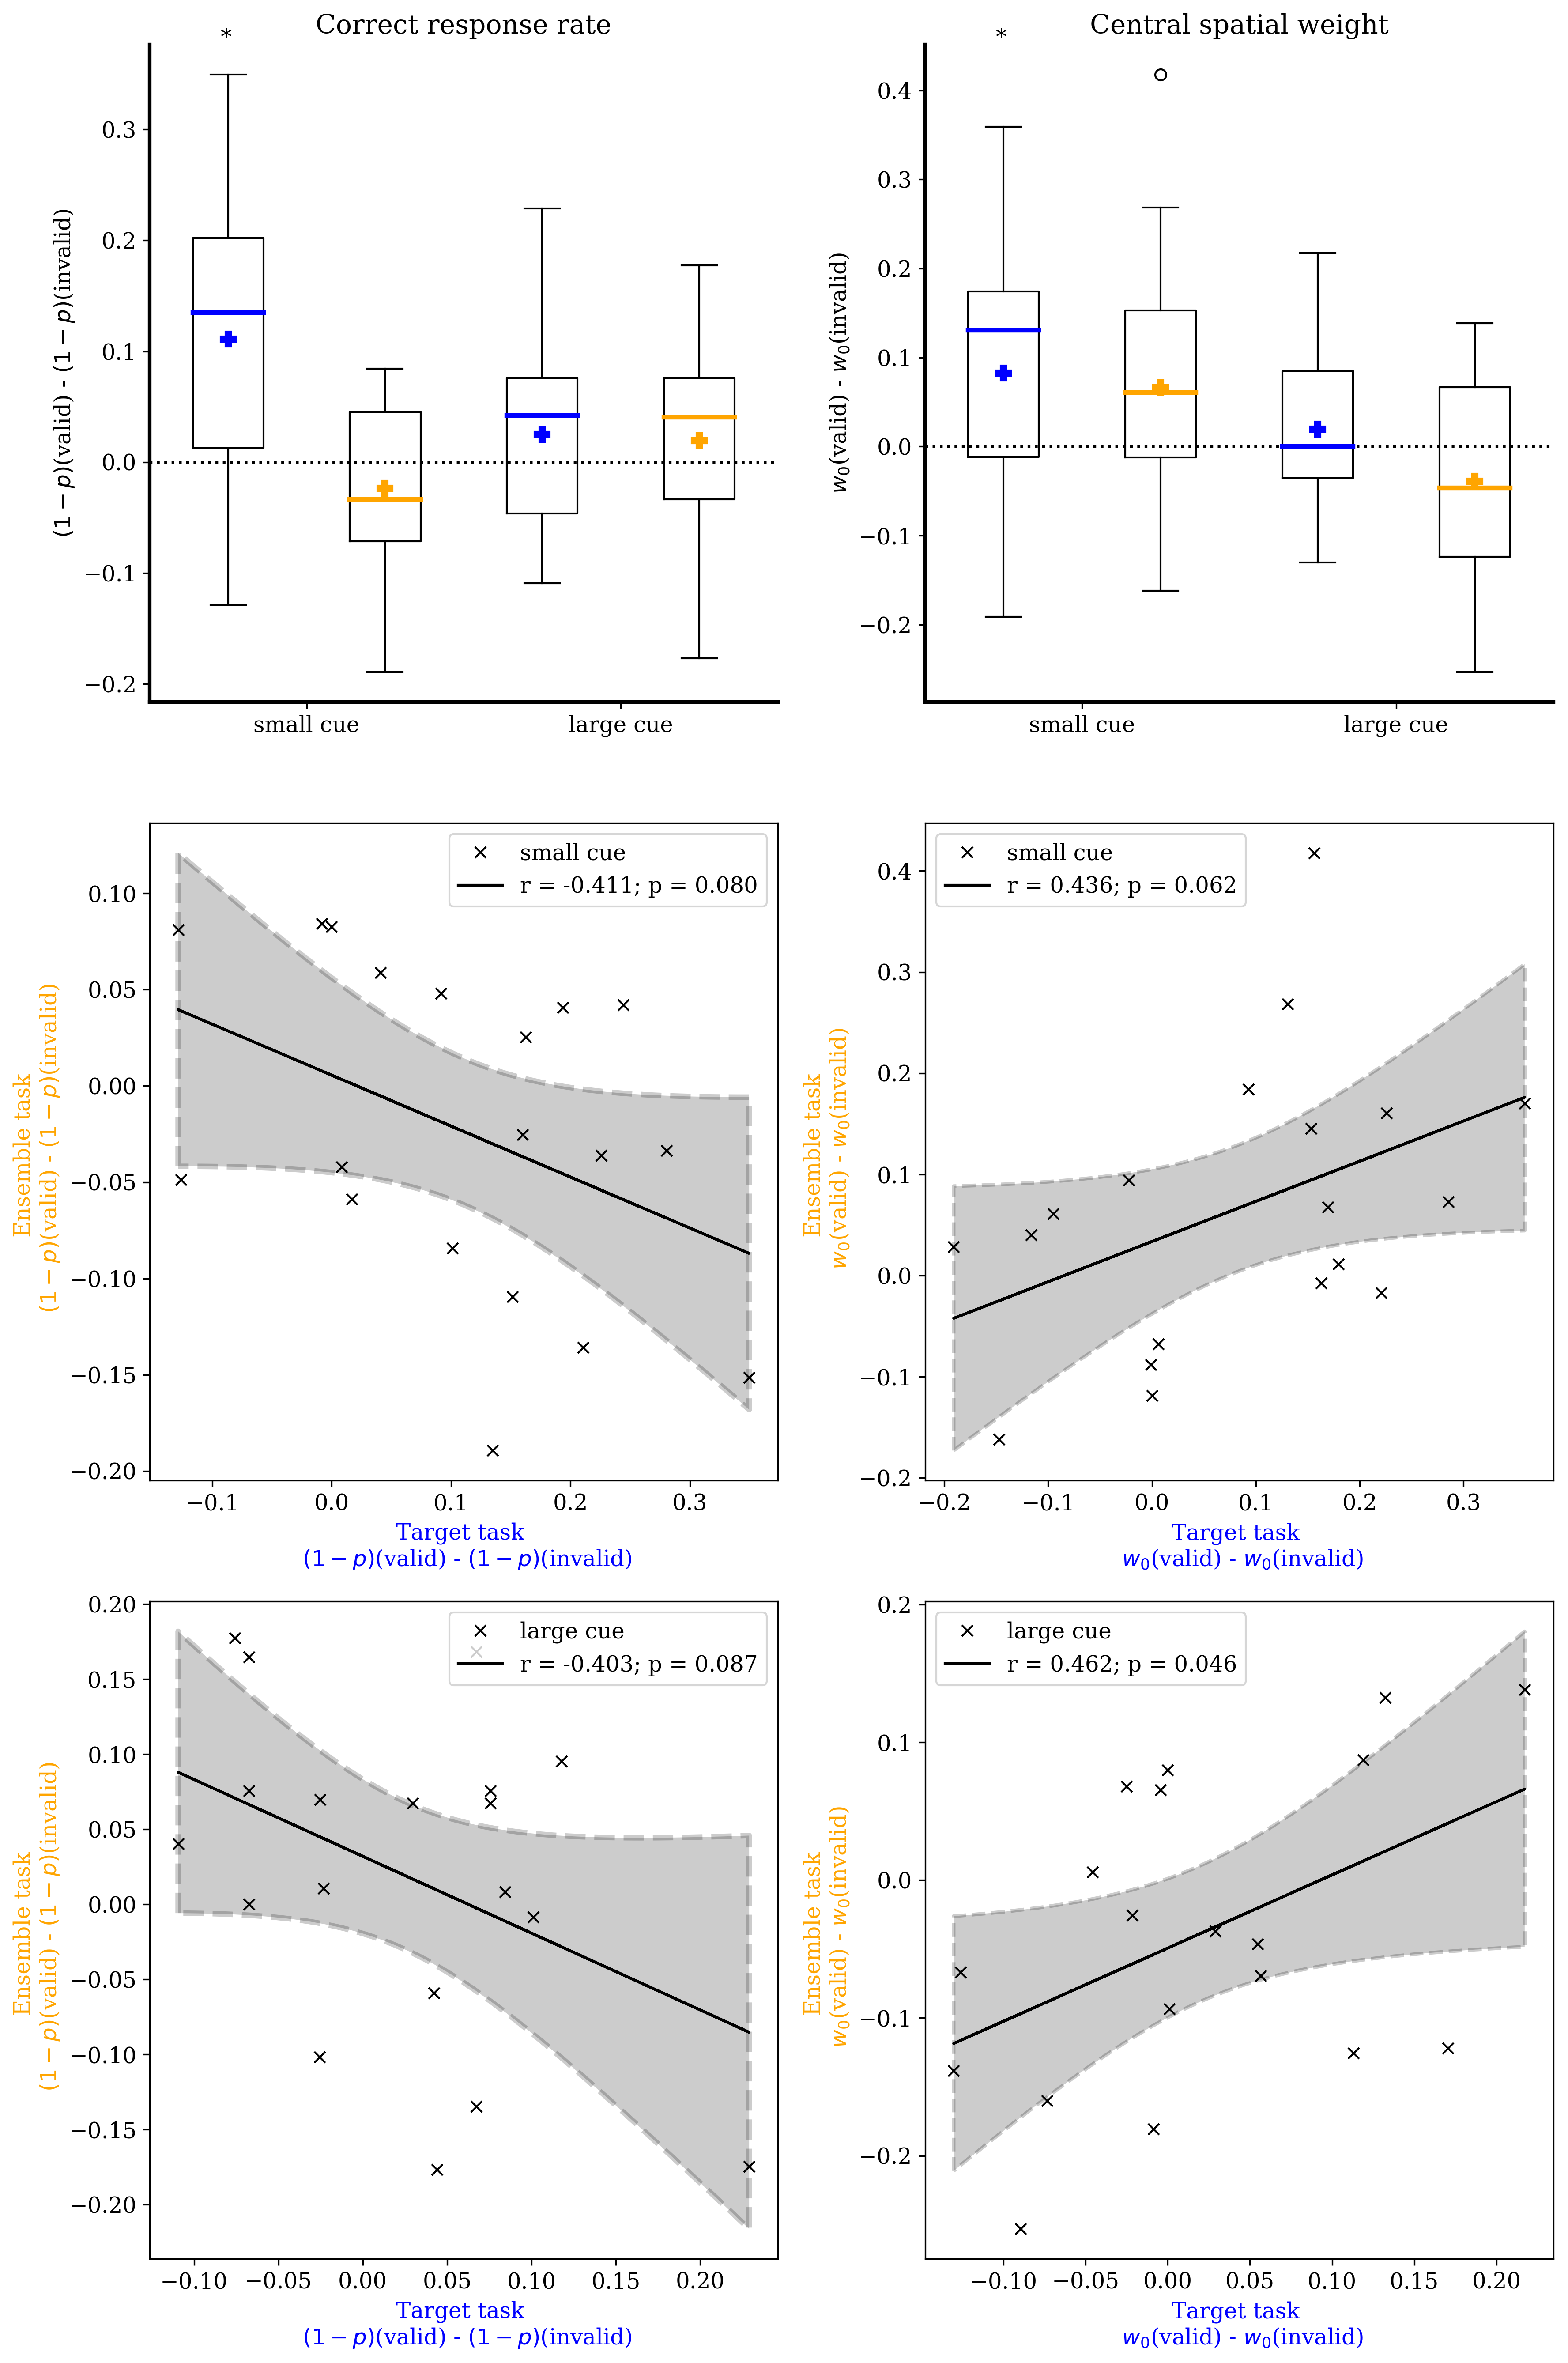

In [21]:
tinv = lambda p, df: abs(scipy.stats.t.ppf(p, df))
line = lambda x,m,b: b+ m*x 

filenames = ['mean_model_fits/target_task_sub.pkl',
             'mean_model_fits/ensemble_task_sub.pkl']

cue_size = ['small', 'big']
task_type = ['target_task', 'ensemble_task']
colors = ['black', 'black']
validity = ['valid', 'invalid']

fig, ax = plt.subplots(3,2 ,figsize=(12,18))


## ============ central spatial weight corr plots ===========
coeffs = [];
d = []
for i, c in enumerate(cue_size):
    out = [[],[]]
    for j, file in enumerate(filenames):
        data = pickle.load(open(file, 'rb'))
        # small
#         s1 = np.squeeze(np.array([param[1] for param in data["small_"+c]['params']]))
        s1 = np.squeeze(np.array([param[1] for param in data[c+"_valid"]['params']]))
        s1 = np.clip(s1, 0, None)
        s1 = s1 / np.sum(s1,axis=1).reshape(19,1)
        s1 = s1[:,0]
        # big
#         s2 = np.squeeze(np.array([param[1] for param in data["big_"+c]['params']]))
        s2 = np.squeeze(np.array([param[1] for param in data[c+"_invalid"]['params']]))
        s2 = np.clip(s2, 0, None)
        s2 = s2 / np.sum(s2,axis=1).reshape(19,1)
        s2 = s2[:,0]
        
        out[j] = s1 - s2
        d.append(s1-s2)

    pfit = np.polyfit(out[0],out[1],1)
    r,p = scipy.stats.pearsonr(out[0], out[1])
    coeffs.append((float(r),float(p)))
    
    # Data
    x,y = out
    ax[1+i,1].plot(x, y, marker='x', markersize=6, linestyle='none', color=colors[i])
    # Regression line
    y_pred = line(x,pfit[0],pfit[1])
    ax[1+i,1].plot(x, y_pred,color=colors[i]) 
    # 95% confidence interval
    df = s1.size - pfit.size
    ts = tinv(.975, df)
    s_err = np.sqrt(np.sum((y - y_pred)**2) / df)
    x_fill = np.linspace(min(x), max(x), 100)
    y_fill = line(x_fill, pfit[0], pfit[1])
    ci = ts * s_err * np.sqrt(1/s1.size + (x_fill - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax[1+i,1].fill_between(x_fill,y_fill+ci,y_fill-ci,color=colors[i], linestyle="--", alpha=.2,
                         edgecolor="", linewidth=2)

    ax[1+i,1].set_ylabel('Ensemble task \n $w_{0}$(valid) - $w_{0}$(invalid)', color='orange')
    ax[1+i,1].set_xlabel('Target task \n $w_{0}$(valid) - $w_{0}$(invalid)', color='blue')
    
ax[0,1].set_title('Central spatial weight')

corr_str = 'r = {0:.3f}; p = {1:.3f}'
ax[1,1].legend(['small cue' ,corr_str.format(*coeffs[0])], 
            loc='upper left')
ax[2,1].legend(['large cue', corr_str.format(*coeffs[1])], 
            loc='upper left')

## ============ central spatial weight box-and-whiskers ===========

boxplot = ax[0,1].boxplot(d, showmeans=True,medianprops=medianprops,
                          meanprops=meanprops,showfliers=True)
[m.set_color(c) for m, c in zip(boxplot['medians'], ['blue', 'orange','blue','orange'])]
[m.set_markeredgecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange','blue','orange'])]
[m.set_markerfacecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange','blue','orange'])]

for x,d_x in enumerate(d):
    tstat, pval = scipy.stats.ttest_1samp(d_x,0)
    if pval < .05:
        print(tstat,pval)
        ax[0,1].text(x+1-.05, ax[0,1].get_ylim()[1], '*')
        


ax[0,1].set_xticks([1.5,3.5])
ax[0,1].set_xticklabels(['small cue', 'large cue'])
ax[0,1].set_ylabel('$w_{0}$(valid) - $w_{0}$(invalid)')
ax[0,1].spines['bottom'].set_linewidth(2)
ax[0,1].spines['left'].set_linewidth(2)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].axhline(0,color='black',linestyle=':')


## ============ correct response rate corr plots ===========


filenames = ['mean_model_fits/target_task_rc_target.pkl',
             'mean_model_fits/ensemble_task_rc_mean.pkl']

coeffs = [];
d = []
for i, c in enumerate(cue_size):
    out = [[],[]]
    for j, file in enumerate(filenames):
        data = pickle.load(open(file, 'rb'))
        # small
#         p1 = 1-np.array(data["small_"+c]['params'])
        p1 = 1-np.array(data[c+"_valid"]['params'])
        p1 = np.clip(p1, 0, 1)
        # big
#         p2 = 1-np.array(data["big_"+c]['params'])
        p2 = 1-np.array(data[c+"_invalid"]['params'])
        p2 = np.clip(p2, 0, 1)
        
        out[j] = np.squeeze(p1 - p2)
        d.append(np.squeeze(p1 - p2).tolist())

    pfit = np.polyfit(out[0],out[1],1)
    r,p = scipy.stats.pearsonr(out[0], out[1])
    coeffs.append((float(r),float(p)))
    
    # Data
    x,y = out
    ax[1+i,0].plot(x, y, marker='x', markersize=6, linestyle='none', color=colors[i])
    # Regression line
    y_pred = line(x,pfit[0],pfit[1])
    ax[1+i,0].plot(x, y_pred,color=colors[i]) 
    # 95% confidence interval
    df = s1.size - pfit.size
    ts = tinv(.975, df)
    s_err = np.sqrt(np.sum((y - y_pred)**2) / df)
    x_fill = np.linspace(min(x), max(x), 100)
    y_fill = line(x_fill, pfit[0], pfit[1])
    ci = ts * s_err * np.sqrt(1/s1.size + (x_fill - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax[1+i,0].fill_between(x_fill,y_fill+ci,y_fill-ci,color=colors[i], linestyle="--", alpha=.2,
                         edgecolor="",linewidth=3)


    ax[1+i,0].set_ylabel('Ensemble task \n $(1-p)$(valid) - $(1-p)$(invalid)', color='orange')
    ax[1+i,0].set_xlabel('Target task \n $(1-p)$(valid) - $(1-p)$(invalid)', color='blue')
    
ax[0,0].set_title('Correct response rate')
# plt.xlim(-.)

corr_str = 'r = {0:.3f}; p = {1:.3f}'
ax[1,0].legend(['small cue' ,corr_str.format(*coeffs[0])],
               loc='upper right')
ax[2,0].legend(['large cue', corr_str.format(*coeffs[1])],
               loc='upper right')

## ============ correct response rate box-and-whiskers ===========


boxplot = ax[0,0].boxplot(d, showmeans=True,medianprops=medianprops,
                          meanprops=meanprops,showfliers=True)
[m.set_color(c) for m, c in zip(boxplot['medians'], ['blue', 'orange','blue','orange'])]
[m.set_markeredgecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange','blue','orange'])]
[m.set_markerfacecolor(c) for m, c in zip(boxplot['means'], ['blue', 'orange','blue','orange'])]

for x,d_x in enumerate(d):
    tstat, pval = scipy.stats.ttest_1samp(d_x,0)
    if pval < .05:
        print(tstat,pval)
        ax[0,0].text(x+1-.05, ax[0,0].get_ylim()[1], '*')

ax[0,0].set_xticks([1.5,3.5])
ax[0,0].set_xticklabels(['small cue', 'large cue'])
ax[0,0].set_ylabel('$(1-p)$(valid) - $(1-p)$(invalid)')
ax[0,0].spines['bottom'].set_linewidth(2)
ax[0,0].spines['left'].set_linewidth(2)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].axhline(0,color='black',linestyle=':')
fig.tight_layout()

In [22]:
fig.savefig('figures/cueing_effects.png', dpi=300, bbox_inches='tight')

In [ ]:
tinv = lambda p, df: abs(scipy.stats.t.ppf(p, df))
line = lambda x,m,b: b+ m*x 

filenames = ['mean_model_fits/target_task_rc_target.pkl',
             'mean_model_fits/ensemble_task_rc_mean.pkl']

cue_size = ['small', 'big']
task_type = ['target_task', 'ensemble_task']
colors = ['green', 'red']
validity = ['valid', 'invalid']

coeffs = [];
for i, c in enumerate(validity):
    out = [[],[]]
    for j, file in enumerate(filenames):
        data = pickle.load(open(file, 'rb'))
        # small
        p1 = 1-np.array(data["small_"+c]['params'])
#         p1 = 1-np.array(data[c+"_valid"]['params'])
        p1 = np.clip(p1, 0, 1)
        # big
        p2 = 1-np.array(data["big_"+c]['params'])
#         p2 = 1-np.array(data[c+"_invalid"]['params'])
        p2 = np.clip(p2, 0, 1)
        
        out[j] = np.squeeze(p1 - p2)

    pfit = np.polyfit(out[0],out[1],1)
    r,p = scipy.stats.pearsonr(out[0], out[1])
    coeffs.append((float(r),float(p)))
    
    # Data
    x,y = out
    ax[0].plot(x, y, marker='x', markersize=6, linestyle='none', color=colors[i])
    # Regression line
    y_pred = line(x,pfit[0],pfit[1])
    ax[0].plot(x, y_pred,color=colors[i]) 
    # 95% confidence interval
    df = s1.size - pfit.size
    ts = tinv(.975, df)
    s_err = np.sqrt(np.sum((y - y_pred)**2) / df)
    x_fill = np.linspace(min(x), max(x), 100)
    y_fill = line(x_fill, pfit[0], pfit[1])
    ci = ts * s_err * np.sqrt(1/s1.size + (x_fill - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax[0].fill_between(x_fill,y_fill+ci,y_fill-ci,color=colors[i], linestyle="--", alpha=.2, edgecolor="")


ax[0].set_ylabel('Ensemble task \n $(1-p)$(small) - $(1-p)$(large)', color='orange')
ax[0].set_xlabel('Target task \n $(1-p)$(small) - $(1-p)$(large)', color='blue')
# plt.xlim(-.)

corr_str = 'r = {0:.3f}; p = {1:.3f}'
ax[0].legend(['valid trials' ,corr_str.format(*coeffs[0]) ,'invalid trials', corr_str.format(*coeffs[1])])

In [ ]:
np.squeeze(out[0])

In [ ]:
x = np.linspace(-np.pi/2,0,100)
sigmoid = lambda x,l: 1 / (1+np.exp(-l*(x+np.pi/4)))

filenames = ['mean_model_fits/target_task_sub.pkl',
             'mean_model_fits/ensemble_task_sub.pkl']

names = ['target_task', 'ensemble_task']
colors = ['blue', 'orange']
markers = ['o', 'o']

fig,ax = plt.subplots(1,2, figsize=(10,5))

for i, file in enumerate(filenames):
    for j,key in enumerate(cond_keys):
        data = pickle.load(open(file, 'rb'))
        lamb = np.mean(np.array([param[2] for param in data[key]['params']]))
        ax[i].plot(x+(.01*j),sigmoid(x,lamb), linewidth=3, alpha=.75)
        
    ax[i].set_title(names[i])
    ax[i].legend(cond_keys)
    ax[i].set_ylim(0,1)
    ax[i].set_xlabel("Orientation Error")
    ax[i].set_ylabel("Probability")

In [ ]:
filenames = ['mean_model_fits/target_task_sub.pkl', 
             'mean_model_fits/ensemble_task_sub.pkl']

theta = radar_factory(9, frame='polygon')

fig, ax= plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'))

fig.subplots_adjust(wspace=0, hspace=0, top=0.85, bottom=0.05)

key_txt = '{cue_size}_{validity}'
trial_type = ['valid', 'invalid']
colors = ['blue', 'red']
cue_type = ['small', 'big']
titles = ['Valid Trials', 'Invalid Trials']
task_type = ["Target Task", "Ensemble Task"]

for k, file in enumerate(filenames):
    data = pickle.load(open(file, 'rb'))
    for i, t in enumerate(trial_type):
        legend_handles = []
        for j,c in enumerate(cue_type):
            key = key_txt.format(cue_size=c,validity=t)
            s = np.squeeze(np.array([param[1] for param in data[key]['params']]))
            s = s / np.sum(s,axis=1).reshape(19,1)
            d = np.mean(s[:,1:],axis=0)

            ax[k,i].set_rgrids([0.03, 0.06, 0.09, 0.12,.15,.18])
            ax[k,i].plot(theta, d, color=colors[j])
            ax[0,i].set_title(titles[i],position=(0.5, 1.1))
            ax[k,i].fill(theta, d, facecolor=colors[j], alpha=0.25, label='_nolegend_')
            ax[k,i].set_ylim(0,.2)
            ax[k,i].set_varlabels([None,]*9)
            ax[k,0].set_ylabel(task_type[k], position=(-.5,.5))
            
            legend_handles.append(Line2D([0], [0], color=colors[j],
                     label=cue_type[j],lw=5))
            
fig.legend(handles=legend_handles)    
# fig.text(0.5, 0, 'Cue Validity', ha='center');

In [ ]:
x = np.linspace(-np.pi/4,np.pi/4,num=1000)
sigmoid = lambda x,l: 1 / (1+np.exp(-l*(x)))

fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
lambs = [2, 8, 16]
for l in lambs:
    ax.plot(x,sigmoid(x,l), linewidth=2, label=str(l))

ax.legend(title='$\lambda$')
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Probability')
ax.set_xlabel('Orientation similarity')



In [ ]:
fig.savefig('figures/lambda_demo.png', dpi=300, bbox_inches='tight')